In [25]:
import shap
import pandas as pd
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# count the number of outcomes in a traget variable
y #y is a np.array
import numpy as np
unique, counts = np.unique(y, return_counts=True)
dict(zip(unique, counts))

{0: 212, 1: 357}

In [4]:
357/(212+357)

0.6274165202108963

1. The "Noise & Redundancy" Stress Test

This is a classic "Sanity Check" experiment that looks great in a thesis because it empirically proves the theoretical properties of SHAP vs. PFI.

The Setup:

Take your Breast Cancer dataset.

Add a Noise Feature: Generate a column of random numbers (Gaussian noise).

Add a Redundant Feature: Take the most important feature (e.g., worst texture) and duplicate it exactly as worst texture_copy.

The Experiment: Re-train the model and calculate SHAP and PFI.

What to look for (The Story):

Noise: Does the method correctly assign near-zero importance to the random noise? (Some methods overfittingly assign it value).

Redundancy: This is the key.

    TreeSHAP typically splits the importance roughly 50/50 between the original and the copy.

    PFI often assigns zero (or very low) importance to both. Why? Because when you permute one, the model still has the perfect copy to rely on, so the error doesn't increase.

Visualization: A bar chart zooming in on just the Top Feature, its Copy, and the Noise feature for both methods.

1. **OK** Rank Agreement PFI vs SHAP per model (per dataset)
2. Porównać ten chart z feature selection z większą ilością modeli
3. Compare Top 10 Features found by LR vs XGB (using SHAP as the gold standard for attribution)
4. Runtime & Computation Cost
5. PARTITION EXPLAINER

# Czy wybrana pierwsza kolumna dla regresji logistycznej to ta z największym Corr z targetem (dla SHAP i PFI)? Odp: Nie

Here is the mathematical proof for the Additivity property specifically within the SHAP framework.

This proof relies on the **Linearity of Expectation** (or linearity of the integral), which allows us to decompose the characteristic function of a summed model into the sum of the characteristic functions of its parts.

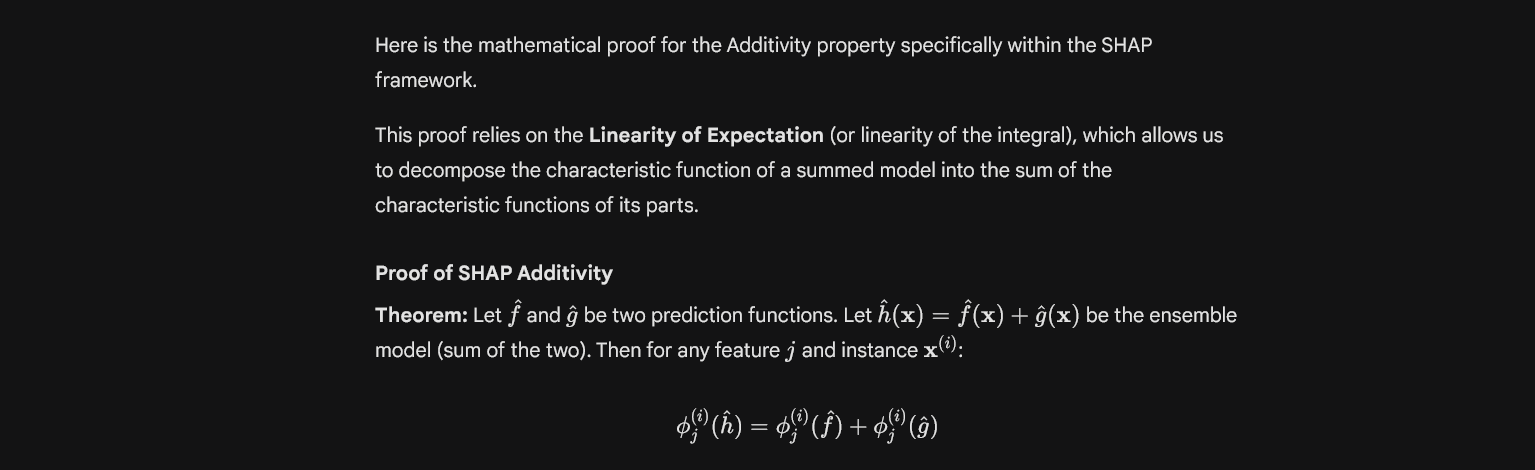

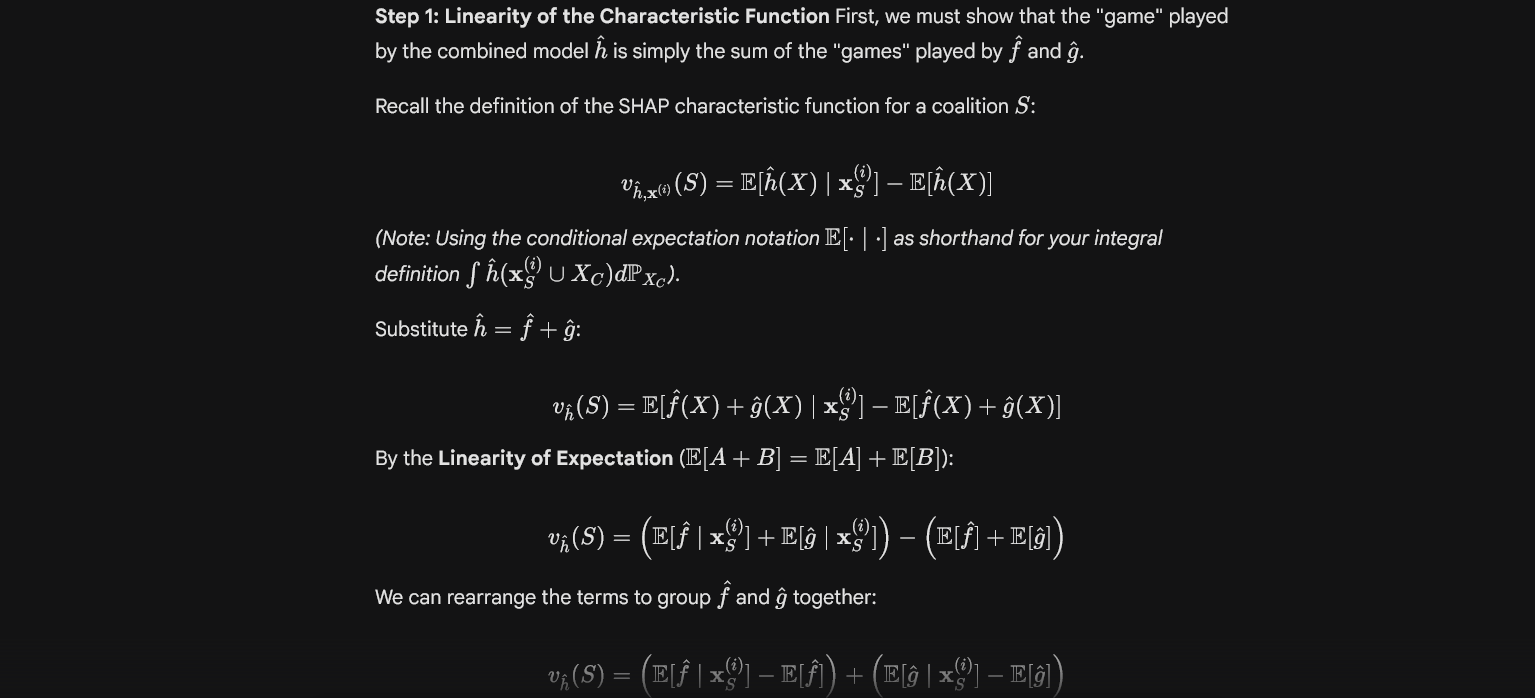

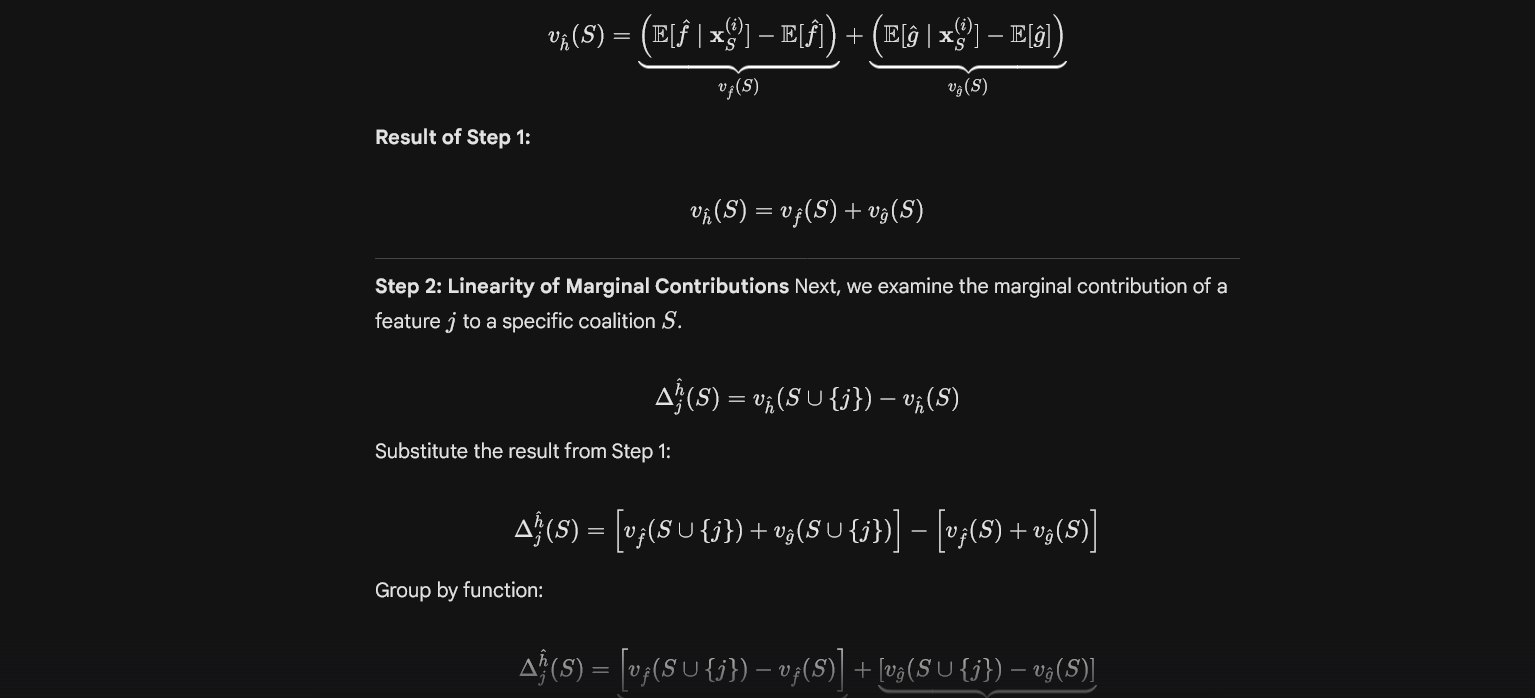

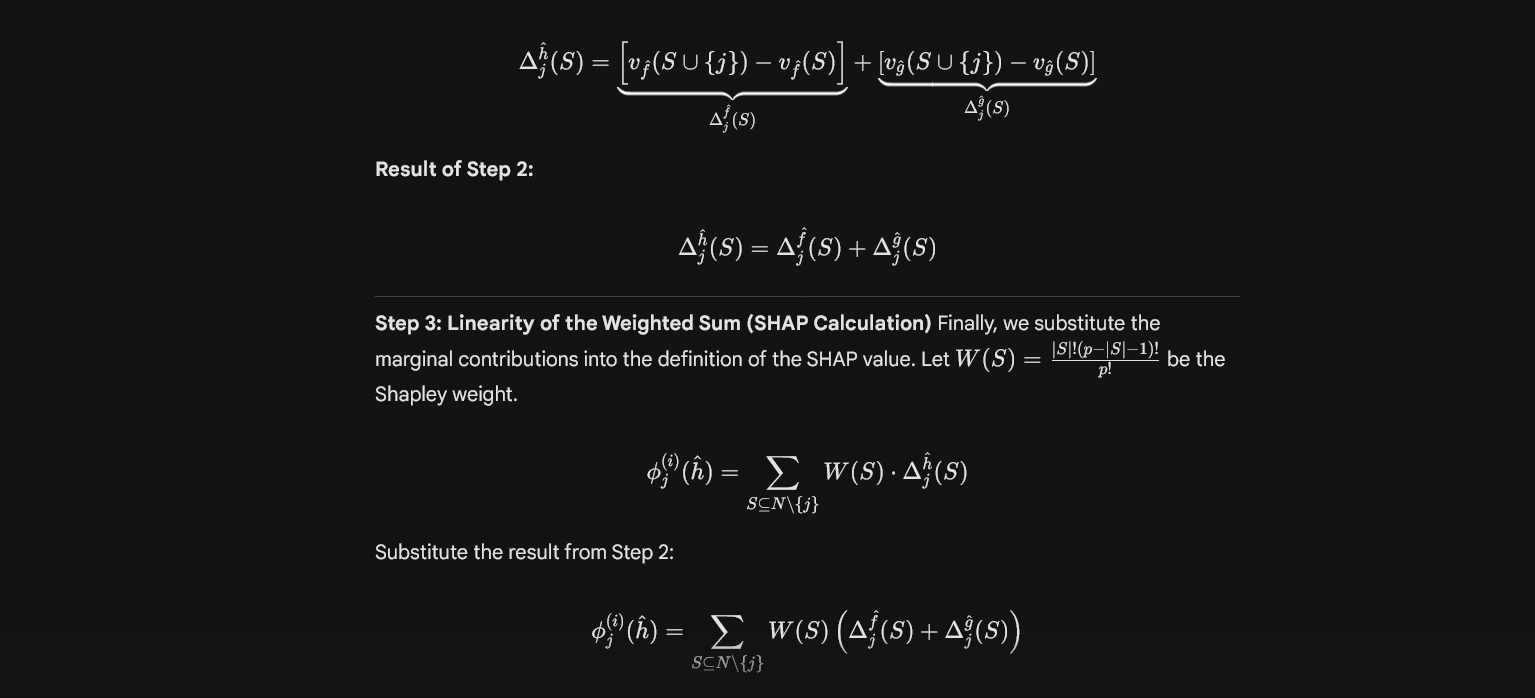

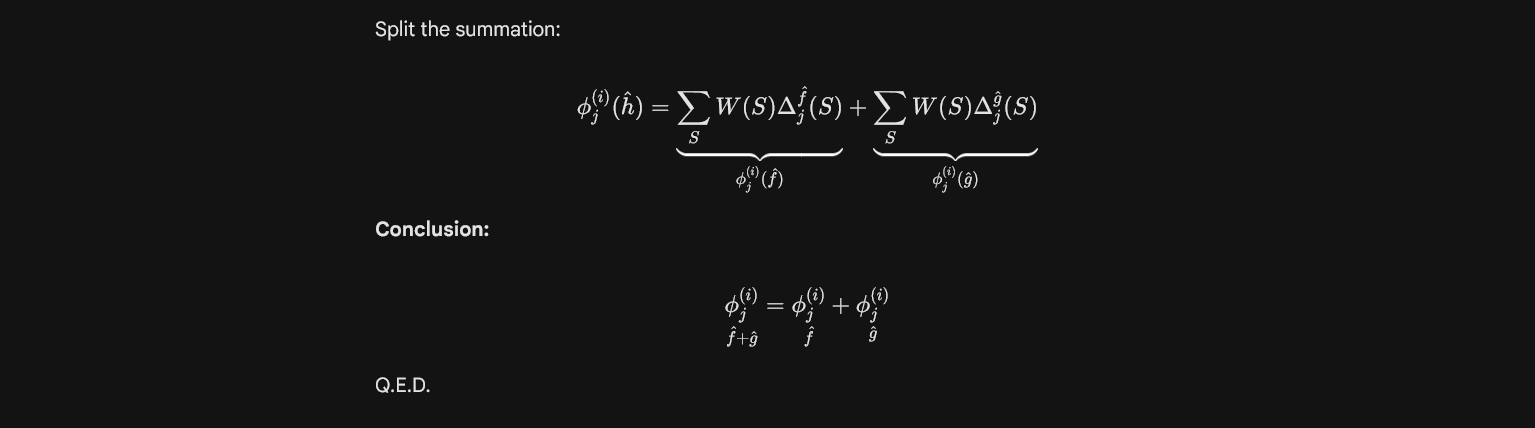

In [1]:
# 🖼️ Matplotlib settings

import warnings
import matplotlib.pyplot as plt
#sns.set_style("whitegrid")

plt.rcParams.update({
    'text.usetex': True,          # Enable LaTeX rendering
    'font.family': 'serif',       # Use serif fonts for a classic look
    'font.serif': ['Georgia'],    # Specify a serif font (e.g., Georgia)
    'font.weight': 'bold',      # Specify font weight                           ----------
    'figure.dpi': 200,            # Set the default DPI for clear visuals
    'figure.facecolor': 'white',  # Set the figure background color
    "axes.edgecolor": "grey",     # Border color for axes
    "axes.linewidth": 0.2,        # Border width for axes
    'axes.grid': True,            # Enable grid on axes
    'axes.labelweight': 'bold',       # Axis label bold                         ----------
    'axes.titleweight': 'bold',     # Axis title bold                           ----------
    'grid.color': 'grey',         # Grid color
    'grid.linestyle': '--',       # Dashed grid line style
    'grid.linewidth': 0.3,       # Grid line width
    'grid.alpha': 0.5,            # Grid transparency
    "axes.spines.top": False,     # Remove top spine
    "axes.spines.right": False,   # Remove right spine
    "legend.frameon": True,       # Enable frame around legends
    "legend.framealpha": 0.5      # Legend frame transparency
})

warnings.filterwarnings('ignore')

legend_box = dict(boxstyle="round,pad=0.3", fc="white", ec="0.8", alpha=0.9)

In [2]:
import shap
import numpy as np
from SHAP_helper.shap_store import load_shap

data = load_shap("shap_results/adult_xgboost.pkl")

shap_values = data["shap_values"]
feature_names = data["feature_names"]

# Global importance
mean_abs = np.abs(shap_values).mean(axis=0)

for f, v in sorted(zip(feature_names, mean_abs), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{f}: {v:.4f}")


Age: 0.8706
Relationship: 0.7967
Marital Status: 0.5155
Capital Gain: 0.4849
Education-Num: 0.4651
Hours per week: 0.4585
Occupation: 0.4441
Sex: 0.2272
Capital Loss: 0.2229
Workclass: 0.0909


In [7]:
import numpy as np
# 1. Load & Split Data
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

#check class distribution
print(data.target_names)
# Output: ['malignant' 'benign']

['malignant' 'benign']


In [ ]:
import shap
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# 1. Load & Split Data
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target
y = 1 - data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Train Logistic Regression
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

model_lr = LogisticRegression(max_iter=1000) # solver='liblinear'
model_lr.fit(X_train_scaled, y_train)

explainer_lr = shap.LinearExplainer(model_lr, X_train_scaled)
shap_values_lr = explainer_lr(X_test_scaled)

# 3. Train XGBoost
model_xgb = xgb.XGBClassifier(
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)
#model_xgb = RandomForestClassifier(random_state=42)
model_xgb.fit(X_train, y_train)

explainer_xgb = shap.TreeExplainer(model_xgb)
shap_values_xgb = explainer_xgb(X_test)

# 4. Plot Side-by-Side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 12))

# Plot 1: Logistic Regression
plt.sca(axes[0]) # Set current axis to the left subplot
plt.title("Logistic Regression", fontsize=16)
shap.summary_plot(shap_values_lr, X_test_scaled, show=False, plot_size=None, color_bar=False, max_display=30)

# Plot 2: XGBoost
plt.sca(axes[1]) # Set current axis to the right subplot
plt.title("XGBoost", fontsize=16)
shap.summary_plot(shap_values_xgb, X_test, show=False, plot_size=None, color_bar=True, max_display=30)

plt.tight_layout()
plt.show()

# 5. Print XGBoost Feature Importance Metrics
booster = model_xgb.get_booster()

importance_types = ["gain", "cover", "weight"]

for imp_type in importance_types:
    print(f"\nXGBoost Feature Importance ({imp_type.upper()}):")
    
    scores = booster.get_score(importance_type=imp_type)
    
    # Convert to DataFrame
    df_importance = (
        pd.DataFrame(scores.items(), columns=["feature", imp_type])
        .sort_values(by=imp_type, ascending=False)
        .reset_index(drop=True)
    )
    
    print(df_importance)
    
# 6. Print SHAP Feature Importance (mean |SHAP value|)

def print_shap_importance(shap_values, X, model_name):
    # Handle new SHAP object format
    if hasattr(shap_values, "values"):
        values = shap_values.values
    else:
        values = shap_values

    shap_importance = (
        pd.DataFrame({
            "feature": X.columns,
            "mean_abs_shap": abs(values).mean(axis=0)
        })
        .sort_values("mean_abs_shap", ascending=False)
        .reset_index(drop=True)
    )

    print(f"\n{model_name} — SHAP Feature Importance (mean |SHAP|)")
    print(shap_importance)

print_shap_importance(shap_values_lr, X_test_scaled, "Logistic Regression")
print_shap_importance(shap_values_xgb, X_test, "XGBoost")


KeyboardInterrupt: 

ImportError: numpy._core.multiarray failed to import

C:\Users\jk200\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\core.py:158: UserWarning: [12:36:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


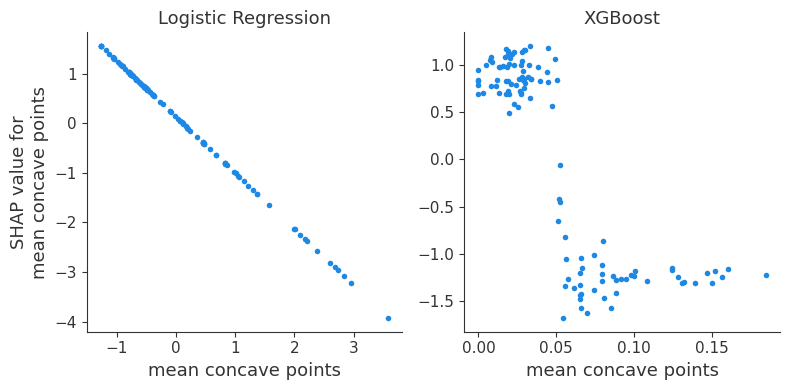

In [2]:
import shap
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# 1. Prepare Data
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Logistic Regression (Linear)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

model_lr = LogisticRegression(solver='liblinear')
model_lr.fit(X_train_scaled, y_train)

explainer_lr = shap.LinearExplainer(model_lr, X_train_scaled)
shap_values_lr = explainer_lr(X_test_scaled)

# 3. XGBoost (Tree/Non-Linear)
model_xgb = xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_xgb.fit(X_train, y_train)

explainer_xgb = shap.TreeExplainer(model_xgb, X_train)
shap_values_xgb = explainer_xgb(X_test)

# 4. Plot Dependence Side-by-Side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

feature_name = "mean concave points"
#feature_name = "worst texture"

# Logistic Regression Plot
plt.sca(axes[0])
shap.dependence_plot(
    feature_name, 
    shap_values_lr.values, 
    X_test_scaled, 
    ax=axes[0], 
    show=False, 
    interaction_index=None,
    title="Logistic Regression"
)

# XGBoost Plot
plt.sca(axes[1])
shap.dependence_plot(
    feature_name, 
    shap_values_xgb.values, 
    X_test, 
    ax=axes[1], 
    show=False, 
    interaction_index=None,
    title="XGBoost"
)
axes[1].set_ylabel("")  # Remove y-axis label for the right plot

plt.tight_layout()
plt.show()

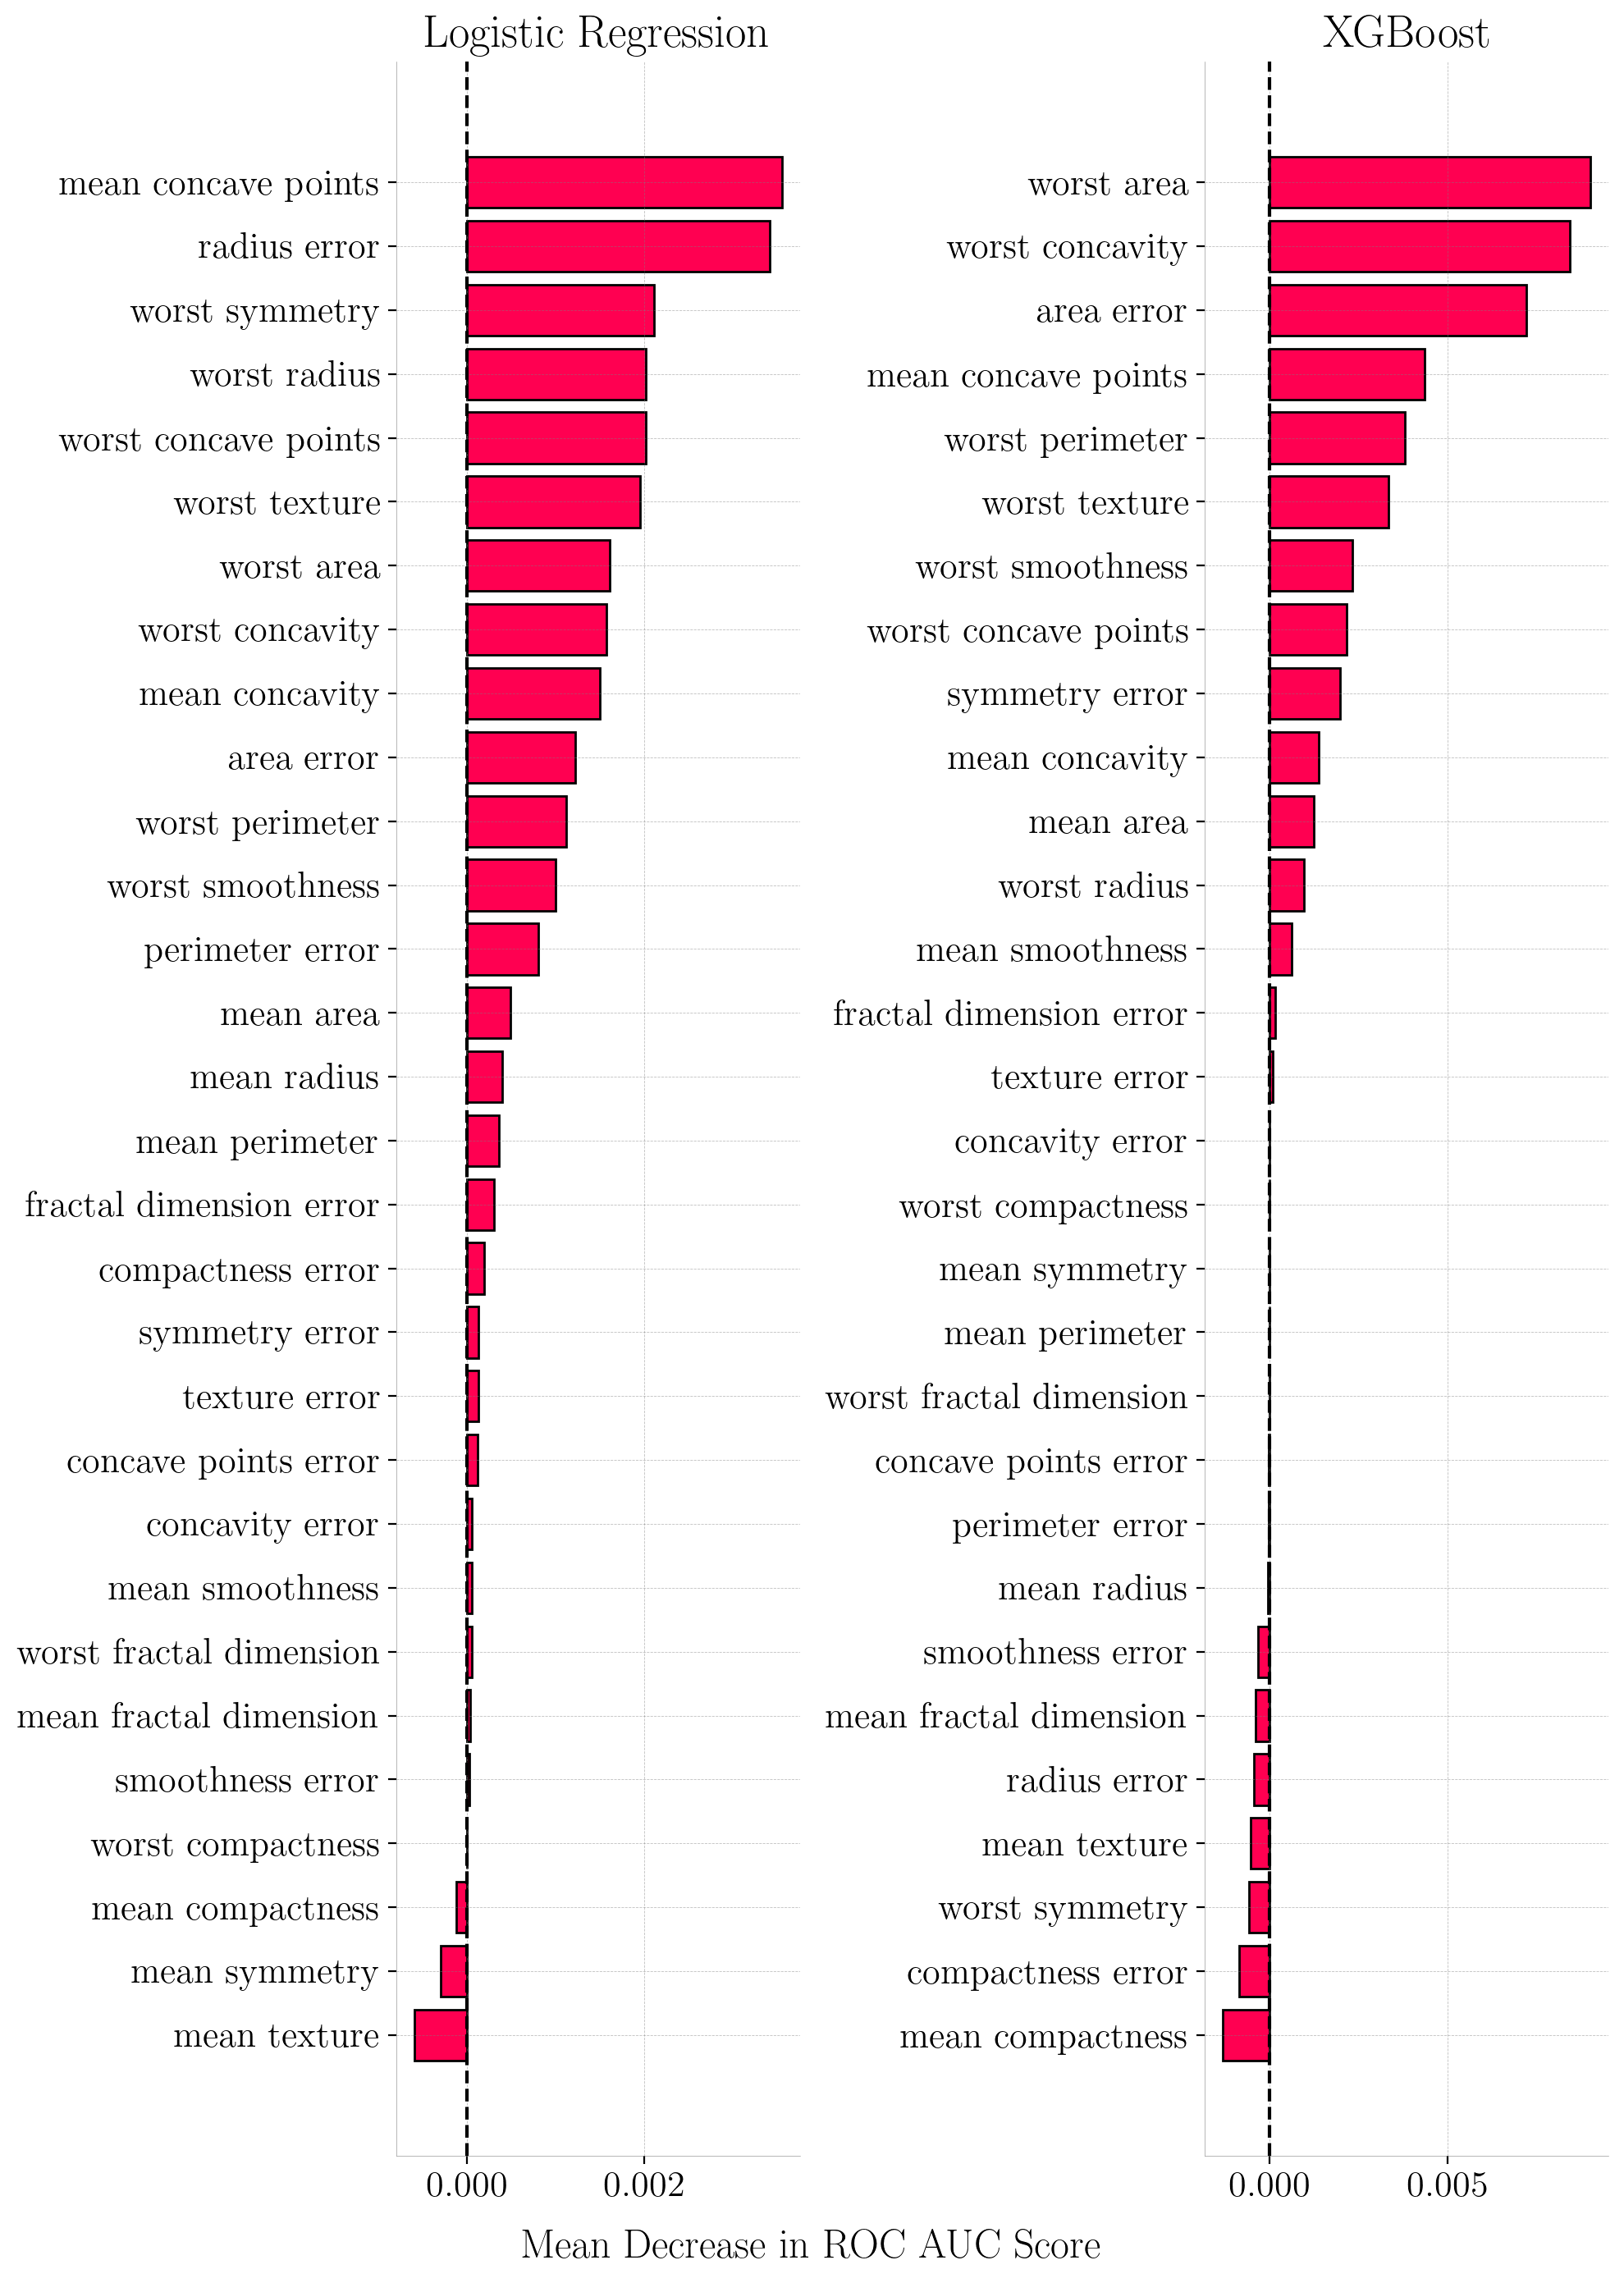

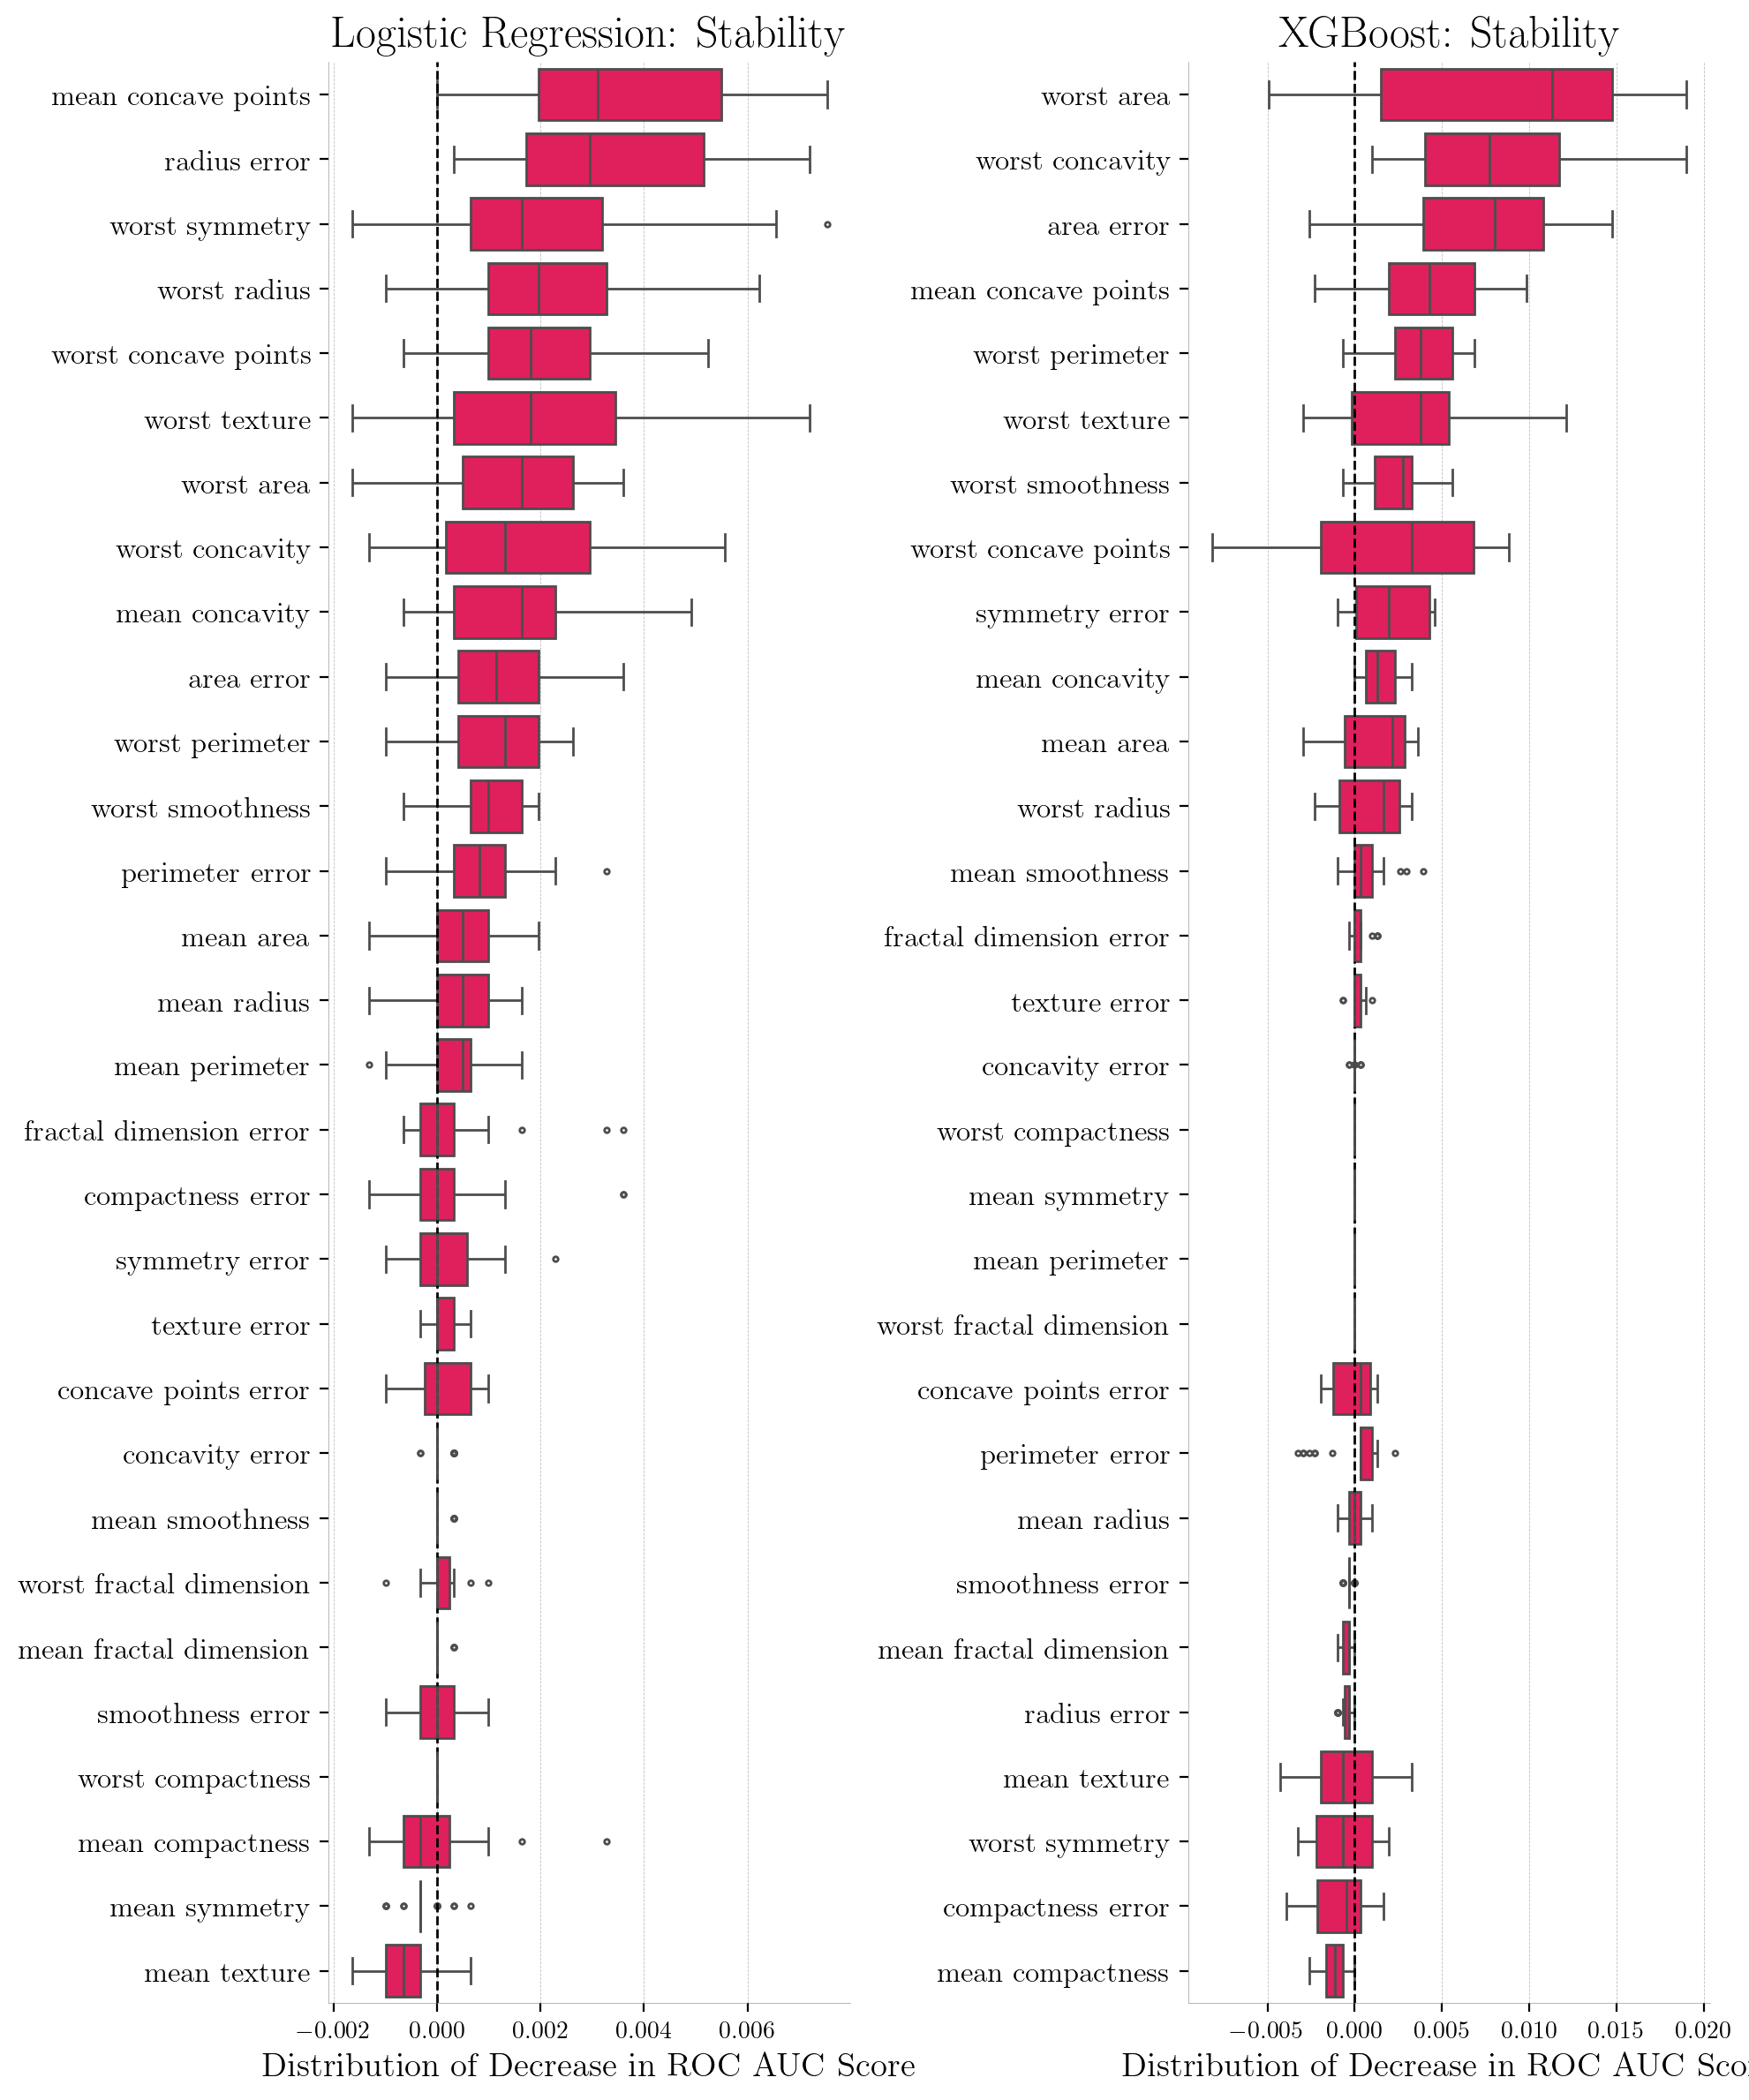

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        43
           1       0.97      0.99      0.98        71

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

Logistic Regression ROC AUC Score:
0.99737962659679
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        43
           1       0.96      0.97      0.97        71

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

XGBoost ROC AUC Score:
0.9908286930887652

Logistic Regression — Permutation Feature Importance (ROC-AUC)
                feature  mean_roc_auc_decrease
    mean concave points               0.003548
           radius er

In [18]:
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import shap
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, roc_auc_score

# --- 1. Load & Prepare Data ---
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale data for Logistic Regression (Linear models need scaling)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

# --- 2. Train Models ---

# Model A: Logistic Regression
model_lr = LogisticRegression(max_iter=1000, random_state=42)
model_lr.fit(X_train_scaled, y_train)

# Model B: XGBoost
model_xgb = xgb.XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)
#model_xgb = RandomForestClassifier(random_state=42)
model_xgb.fit(X_train, y_train)

# --- 3. Compute Permutation Importance (using F1 metric) ---
# We run 30 repeats to generate the distribution for the box plots
r_lr = permutation_importance(model_lr, X_test_scaled, y_test, n_repeats=30, random_state=42, scoring='roc_auc')
r_xgb = permutation_importance(model_xgb, X_test, y_test, n_repeats=30, random_state=42, scoring='roc_auc')

# --- 4. Helper Function to Process Data ---
def process_importance(importance_result, feature_names, top_n=30):
    # Create Summary DF
    df = pd.DataFrame({
        "feature": feature_names,
        "importance_mean": importance_result.importances_mean
    }).sort_values("importance_mean", ascending=False).head(top_n)
    
    # Get the sorted list of features
    sorted_feats = df["feature"].tolist()
    
    # Create Tidy DF for Box Plots (only for the top N features)
    tidy_df = pd.DataFrame(importance_result.importances.T, columns=feature_names)
    tidy_df = tidy_df[sorted_feats].melt(var_name='feature', value_name='importance')
    
    return df, tidy_df, sorted_feats

# Process both results (Top 15 features to keep plots readable)
df_lr, tidy_lr, feats_lr = process_importance(r_lr, X.columns)
df_xgb, tidy_xgb, feats_xgb = process_importance(r_xgb, X.columns)

# --- 5. Plotting Setup ---
# Define SHAP Red color
shap_red = mcolors.to_hex(shap.plots.colors.red_blue(1.0))

# --- Plotting Part 1: Feature Importance Rankings (Bar Charts) ---
fig1, axes1 = plt.subplots(nrows=1, ncols=2, figsize=(10, 14))

# Plot 1 (Left): Logistic Regression Bar Chart
axes1[0].barh(df_lr["feature"], df_lr["importance_mean"], color=shap_red, edgecolor="black")
axes1[0].invert_yaxis()
axes1[0].set_title("Logistic Regression", fontsize=20)
#axes1[0].set_xlabel("Mean Decrease in ROC AUC Score", fontsize=16)
axes1[0].axvline(0, color='k', linestyle='--')
axes1[0].tick_params(axis='y', labelsize=16)
axes1[0].tick_params(axis='x', labelsize=16)

# Plot 2 (Right): XGBoost Bar Chart
axes1[1].barh(df_xgb["feature"], df_xgb["importance_mean"], color=shap_red, edgecolor="black")
axes1[1].invert_yaxis()
axes1[1].set_title("XGBoost", fontsize=20)
#axes1[1].set_xlabel("Mean Decrease in ROC AUC Score", fontsize=16)
axes1[1].axvline(0, color='k', linestyle='--')
axes1[1].tick_params(axis='y', labelsize=16)
axes1[1].tick_params(axis='x', labelsize=16)
fig1.supxlabel("Mean Decrease in ROC AUC Score", fontsize=18)
plt.tight_layout()
plt.show()

# --- Plotting Part 2: Feature Stability (Box Plots) ---
fig2, axes2 = plt.subplots(nrows=1, ncols=2, figsize=(10, 12))

# Plot 1 (Left): Logistic Regression Box Plot
sns.boxplot(
    data=tidy_lr, x='importance', y='feature', order=feats_lr,
    orient='h', ax=axes2[0], color=shap_red, fliersize=2
)
axes2[0].set_title("Logistic Regression: Stability", fontsize=18)
axes2[0].set_xlabel("Distribution of Decrease in ROC AUC Score", fontsize=14)
axes2[0].set_ylabel("")  # Redundant
axes2[0].axvline(0, color='k', linestyle='--', linewidth=1)
axes2[0].tick_params(axis='y', labelsize=12)

# Plot 2 (Right): XGBoost Box Plot
sns.boxplot(
    data=tidy_xgb, x='importance', y='feature', order=feats_xgb,
    orient='h', ax=axes2[1], color=shap_red, fliersize=2
)
axes2[1].set_title("XGBoost: Stability", fontsize=18)
axes2[1].set_xlabel("Distribution of Decrease in ROC AUC Score", fontsize=14)
axes2[1].set_ylabel("")  # Redundant
axes2[1].axvline(0, color='k', linestyle='--', linewidth=1)
axes2[1].tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()

# --- 6. Classification Reports ---
print("Logistic Regression Classification Report:")
y_pred_lr = model_lr.predict(X_test_scaled)
print(classification_report(y_test, y_pred_lr))
print("Logistic Regression ROC AUC Score:")
print(roc_auc_score(y_test, model_lr.predict_proba(X_test_scaled)[:, 1]))

print("XGBoost Classification Report:")
y_pred_xgb = model_xgb.predict(X_test)
print(classification_report(y_test, y_pred_xgb))
print("XGBoost ROC AUC Score:")
print(roc_auc_score(y_test, model_xgb.predict_proba(X_test)[:, 1]))

# --- 7. Print Final PFI Tables (Mean ROC-AUC Decrease) ---

def print_pfi_table(importance_result, feature_names, model_name):
    df = pd.DataFrame({
        "feature": feature_names,
        "mean_roc_auc_decrease": importance_result.importances_mean
    }).sort_values("mean_roc_auc_decrease", ascending=False)
    
    print(f"\n{model_name} — Permutation Feature Importance (ROC-AUC)")
    print(df.to_string(index=False))

print_pfi_table(r_lr, X.columns, "Logistic Regression")
print_pfi_table(r_xgb, X.columns, "XGBoost")


In [33]:
df_xgb

,feature,importance_mean
23,worst area,0.013480
1,mean texture,0.005352
21,worst texture,0.003960
15,compactness error,0.000325
13,area error,0.000000
25,worst compactness,0.000000
22,worst perimeter,0.000000
19,fractal dimension error,0.000000
18,symmetry error,0.000000
17,concave points error,0.000000


In [99]:
corr_df.corr()['target'].abs().sort_values(ascending=False)

target                     1.000000
worst concave points       0.788885
mean concave points        0.778115
worst perimeter            0.774998
worst radius               0.766527
mean perimeter             0.731859
worst area                 0.722875
mean radius                0.718073
mean area                  0.695171
mean concavity             0.683262
worst concavity            0.649952
mean compactness           0.590554
worst compactness          0.588884
radius error               0.540126
perimeter error            0.529211
area error                 0.517064
worst texture              0.467479
worst symmetry             0.440323
worst smoothness           0.430364
mean texture               0.416213
concave points error       0.380240
mean smoothness            0.375137
mean symmetry              0.348123
worst fractal dimension    0.312994
compactness error          0.254370
concavity error            0.216047
smoothness error           0.058123
fractal dimension error    0

In [32]:
df_importance.sort_values('PFI (mean F1 drop)', ascending=False)

NameError: name 'df_importance' is not defined

Loading and preprocessing Breast Cancer dataset...
Training baseline XGBoost model...

=== Baseline Model Classification Report ===
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        43
           1       0.97      0.99      0.98        71

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

Baseline Model ROC AUC Score:
0.99737962659679

Calculating feature rankings...

================ FEATURE RANKINGS WITH VALUES ================

>>> SHAP Ranking (mean |SHAP value|)
                    Feature  SHAP_Importance
0             worst texture         1.141905
1       mean concave points         0.982551
2              radius error         0.865432
3            worst symmetry         0.857923
4           worst concavity         0.737615
5              worst radius         0.718073
6      worst concave points         0.683828

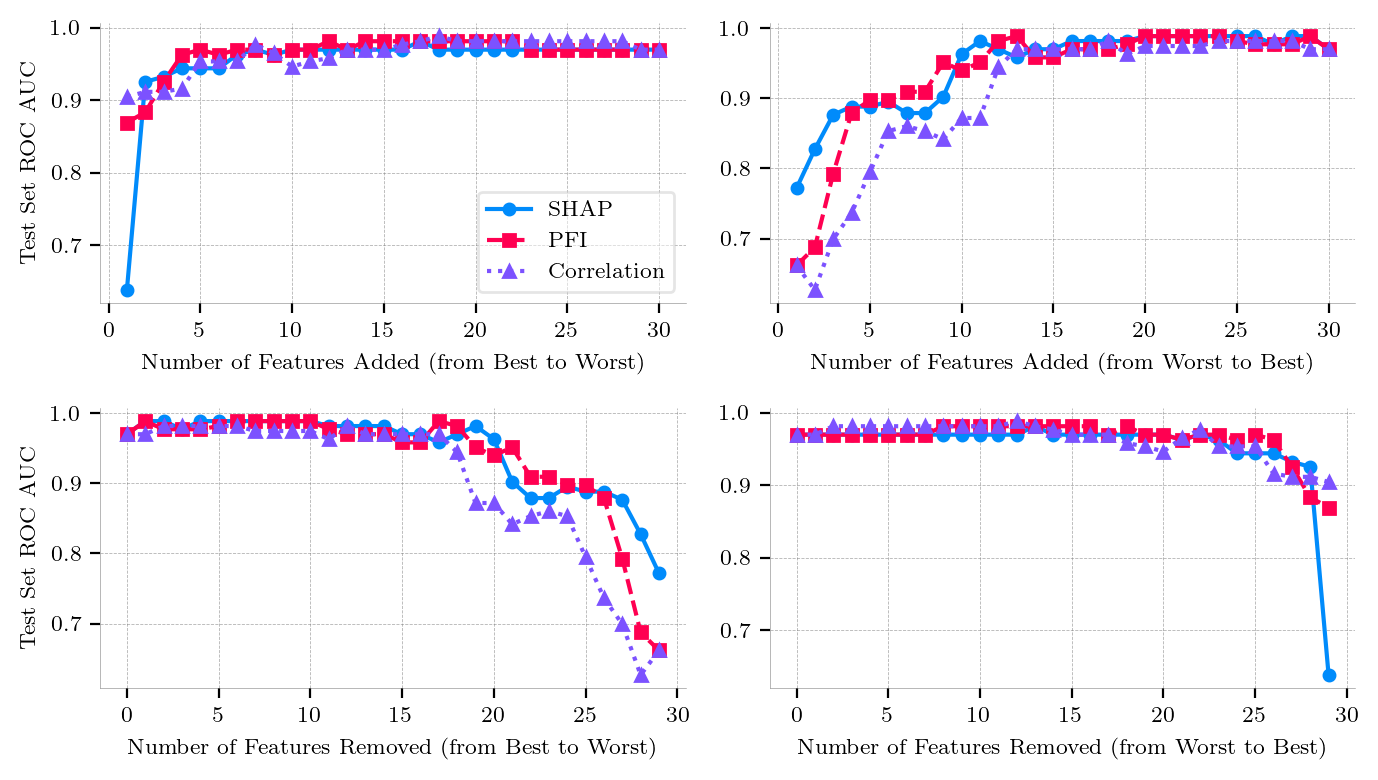

Done.


In [ ]:
#WYRZUCIĆ!
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score, classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression

# ==========================================
# 1. LOAD & PREPROCESS DATA (Breast Cancer Dataset)
# ==========================================
print("Loading and preprocessing Breast Cancer dataset...")
data = load_breast_cancer(as_frame=True)
X = data.data
y = data.target

for col in X.columns:
    if X[col].dtype == 'object' or X[col].dtype.name == 'category':
        X[col] = X[col].fillna(X[col].mode()[0])
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
    else:
        X[col] = X[col].fillna(X[col].mean())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

print("Training baseline XGBoost model...")
model = LogisticRegression(max_iter=1000, random_state=42)
#model = xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42, n_jobs=-1)
model.fit(X_train_scaled, y_train)

baseline_pred = model.predict(X_test_scaled)
print("\n=== Baseline Model Classification Report ===")
print(classification_report(y_test, baseline_pred))
print("Baseline Model ROC AUC Score:")
print(roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1]))
print("============================================\n")

# ==========================================
# 2. CALCULATE IMPORTANCE RANKINGS
# ==========================================
print("Calculating feature rankings...")
feature_names = X.columns.tolist()

# A. SHAP Ranking
explainer = shap.LinearExplainer(model, X_train_scaled)
shap_values = explainer.shap_values(X_test_scaled) 
shap_importance = np.abs(shap_values).mean(axis=0)
shap_ranking = [x for _, x in sorted(zip(shap_importance, feature_names), reverse=True)]

# B. PFI Ranking
pfi = permutation_importance(
    model, X_test_scaled, y_test, n_repeats=50, random_state=42, scoring='roc_auc', n_jobs=-1
)
pfi_ranking = [x for _, x in sorted(zip(pfi.importances_mean, feature_names), reverse=True)]

# C. Correlation Ranking (Pearson)
train_df = X_train_scaled.copy()
train_df['target'] = y_train
corr_values = train_df.corr(method='pearson')['target'].abs().drop('target')
corr_ranking = corr_values.sort_values(ascending=False).index.tolist()

rankings = {"SHAP": shap_ranking, "PFI": pfi_ranking, "Correlation": corr_ranking}

# ==========================================
# 2.1 PRINT FEATURE RANKINGS WITH VALUES
# ==========================================
print("\n================ FEATURE RANKINGS WITH VALUES ================\n")

# A. SHAP
shap_df = pd.DataFrame({
    "Feature": feature_names,
    "SHAP_Importance": shap_importance
}).sort_values("SHAP_Importance", ascending=False)

print(">>> SHAP Ranking (mean |SHAP value|)")
print(shap_df.reset_index(drop=True).to_string(index=True))
print("\n" + "-"*70 + "\n")

# B. Permutation Feature Importance (PFI)
pfi_df = pd.DataFrame({
    "Feature": feature_names,
    "PFI_Importance": pfi.importances_mean
}).sort_values("PFI_Importance", ascending=False)

print(">>> Permutation Feature Importance Ranking (ROC AUC score drop)")
print(pfi_df.reset_index(drop=True).to_string(index=True))
print("\n" + "-"*70 + "\n")

# C. Correlation
corr_df = corr_values.reset_index()
corr_df.columns = ["Feature", "Abs_Pearson_Correlation"]
corr_df = corr_df.sort_values("Abs_Pearson_Correlation", ascending=False)

print(">>> Correlation Ranking (|Pearson r| with target)")
print(corr_df.reset_index(drop=True).to_string(index=True))
print("\n===============================================================\n")


# ==========================================
# 3. EVALUATION LOGIC
# ==========================================
def get_scores(ranking, mode, X_tr, y_tr, X_te, y_te):
    scores = []
    x_axis = []
    n_features = len(ranking)
    
    if 'add' in mode: k_range = range(1, n_features + 1)
    else: k_range = range(0, n_features) 

    for k in k_range:
        if mode == 'add_best':
            selected = ranking[:k]
            x_val = k
        elif mode == 'add_worst':
            selected = ranking[::-1][:k]
            x_val = k
        elif mode == 'remove_best':
            selected = [f for f in ranking if f not in ranking[:k]]
            x_val = k
        elif mode == 'remove_worst':
            bottom_k = ranking[::-1][:k]
            selected = [f for f in ranking if f not in bottom_k]
            x_val = k
            
        if len(selected) == 0: scores.append(0)
        else:
            clf = LogisticRegression(max_iter=1000, random_state=42)
            clf.fit(X_tr[selected], y_tr)
            pred = clf.predict(X_te[selected])
            scores.append(roc_auc_score(y_te, pred))
        x_axis.append(x_val)
    return x_axis, scores

# ==========================================
# 4. PLOTTING THE MATRIX
# ==========================================
print("Generating plots...")

# CHANGED: sharey=False allows each plot to have its own independent y-axis scale
fig, axes = plt.subplots(2, 2, figsize=(7, 4), sharey=False) 

scenarios = [
    ("add_best", axes[0, 0], "Number of Features Added (from Best to Worst)"),
    ("add_worst", axes[0, 1], "Number of Features Added (from Worst to Best)"),
    ("remove_best", axes[1, 0], "Number of Features Removed (from Best to Worst)"),
    ("remove_worst", axes[1, 1], "Number of Features Removed (from Worst to Best)")
]

colors = {"SHAP": "#008BFB", "PFI": "#FF0051", "Correlation": "#7C52FF"}
markers = {"SHAP": 'o', "PFI": 's', "Correlation": '^'}
styles = {"SHAP": '-', "PFI": '--', "Correlation": ':'}

for i, (mode, ax, xlabel_text) in enumerate(scenarios):
    print(f"Running scenario: {mode}...")
    
    for method_name, ranking_list in rankings.items():
        xs, ys = get_scores(ranking_list, mode, X_train_scaled, y_train, X_test_scaled, y_test)
        ax.plot(xs, ys, label=f'{method_name}', color=colors[method_name], 
                marker=markers[method_name], linestyle=styles[method_name], 
                markersize=4, linewidth=1.5)

    # Formatting
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_xlabel(xlabel_text, fontsize=8)
    
    # Show y-label text only on left plots (index 0 and 2)
    # The y-ticks (numbers) will appear on ALL plots because sharey=False
    if i % 2 == 0:
        ax.set_ylabel('Test Set ROC AUC', fontsize=8)
    
    # XTicks for Breast Cancer (0 to 30)
    ax.set_xticks(range(0, 31, 5))
    ax.tick_params(axis='both', labelsize=8)
    
    # Add legend only to the first plot
    if i == 0:
        ax.legend(loc='lower right', fontsize=8)

plt.tight_layout()
plt.show()
print("Done.")

Loading and preprocessing Breast Cancer dataset...
Training baseline Logistic Regression model...
Baseline ROC AUC: 0.9974

Calculating feature rankings...
Generating Iterative Feature Selection Scores...

######################################################################
SCENARIO: ADD BEST
######################################################################

--- Method: SHAP ---
 Step           Feature_Added  ROC_AUC
    1           worst texture 0.752211
    2            radius error 0.932853
    3            worst radius 0.989846
    4              worst area 0.990501
    5    worst concave points 0.997707
    6              area error 0.997380
    7         worst perimeter 0.998035
    8        worst smoothness 0.998690
    9         worst concavity 0.998690
   10          worst symmetry 0.998362
   11     mean concave points 0.998035
   12        mean compactness 0.997707
   13       compactness error 0.998035
   14               mean area 0.998035
   15          mean concav

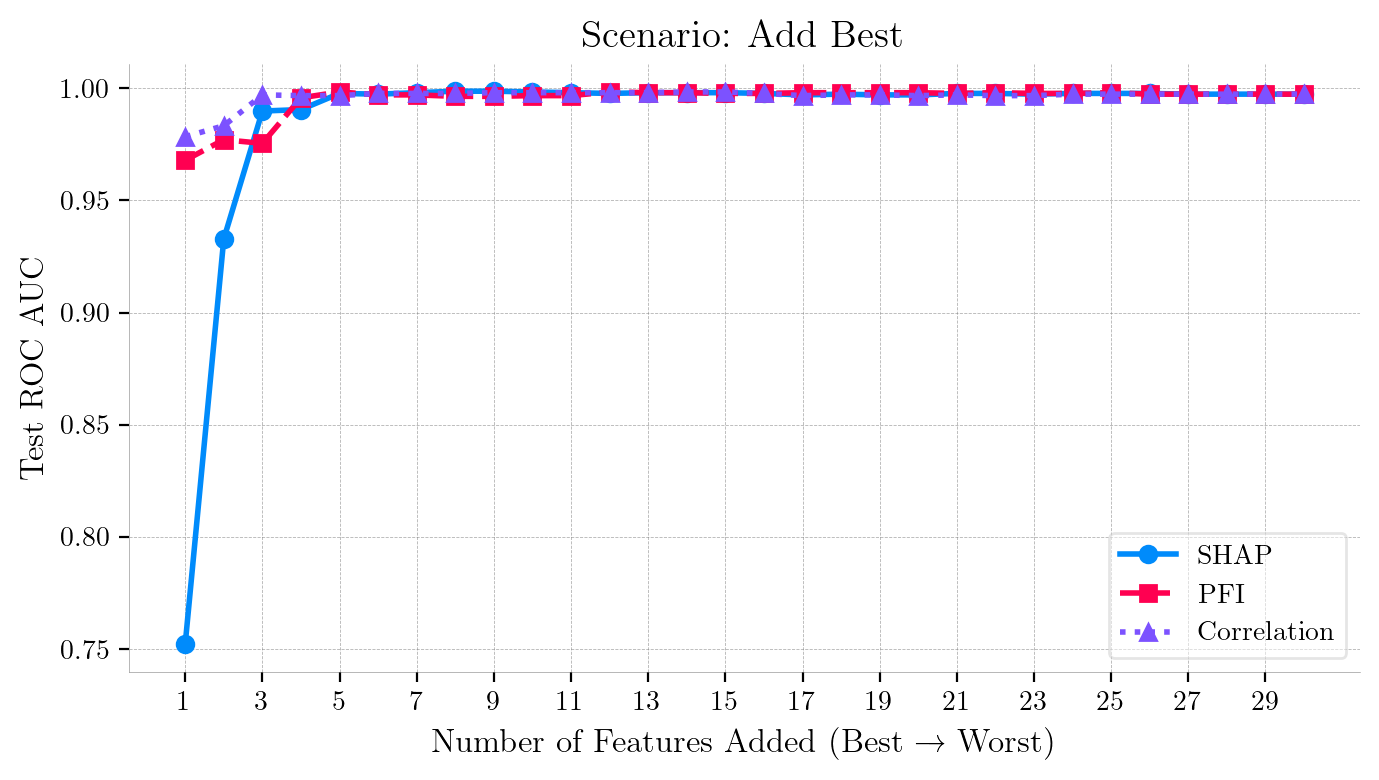

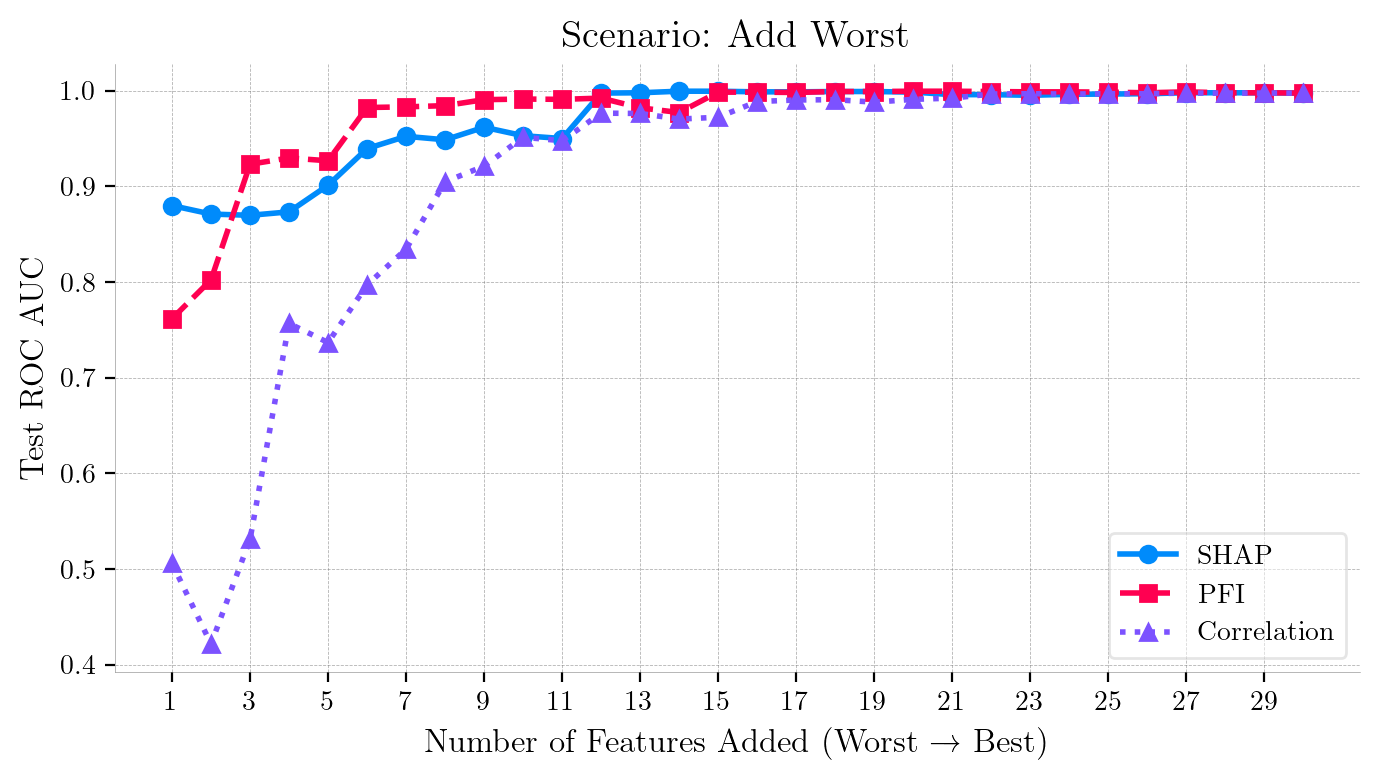

Done.


In [2]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

# ==========================================
# 1. LOAD & PREPROCESS DATA
# ==========================================
print("Loading and preprocessing Breast Cancer dataset...")

data = load_breast_cancer(as_frame=True)
X = data.data
y = data.target
feature_names = X.columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=feature_names,
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=feature_names,
    index=X_test.index
)

print("Training baseline Logistic Regression model...")
baseline_model = LogisticRegression(max_iter=1000, random_state=42)
baseline_model.fit(X_train_scaled, y_train)

baseline_pred = baseline_model.predict_proba(X_test_scaled)[:, 1]
print(f"Baseline ROC AUC: {roc_auc_score(y_test, baseline_pred):.4f}")
print("=" * 60, "\n")

# ==========================================
# 2. FEATURE IMPORTANCE RANKINGS
# ==========================================
print("Calculating feature rankings...")

# --- SHAP (Hardcoded Ranking) ---
# We bypass the TreeExplainer calculation to use the pre-defined order
shap_ranking = [
    "worst texture",
    "radius error",
    "worst radius",
    "worst area",
    "worst concave points",
    "area error",
    "worst perimeter",
    "worst smoothness",
    "worst concavity",
    "worst symmetry",
    "mean concave points",
    "mean compactness",
    "compactness error",
    "mean area",
    "mean concavity",
    "mean radius",
    "mean texture",
    "perimeter error",
    "mean perimeter",
    "concave points error",
    "fractal dimension error",
    "mean smoothness",
    "symmetry error",
    "texture error",
    "mean fractal dimension",
    "worst fractal dimension",
    "mean symmetry",
    "smoothness error",
    "concavity error",
    "worst compactness"
]

# --- Permutation Feature Importance ---
pfi = permutation_importance(
    baseline_model,
    X_test_scaled,
    y_test,
    n_repeats=30,
    random_state=42,
    scoring="roc_auc",
    n_jobs=-1
)
pfi_ranking = [
    f for _, f in sorted(zip(pfi.importances_mean, feature_names), reverse=True)
]

# --- Pearson Correlation ---
train_df = X_train_scaled.copy()
train_df["target"] = y_train.values
corr_values = (
    train_df.corr()["target"]
    .abs()
    .drop("target")
    .sort_values(ascending=False)
)
corr_ranking = corr_values.index.tolist()

rankings = {
    "SHAP": shap_ranking,
    "PFI": pfi_ranking,
    "Correlation": corr_ranking
}

# ==========================================
# 3. FEATURE ADDITION TRAJECTORY (SINGLE SOURCE OF TRUTH)
# ==========================================
def get_trajectory_data(ranking, mode, X_tr, y_tr, X_te, y_te):
    """
    Returns a DataFrame with:
    Step | Feature_Added | ROC_AUC
    """
    results = []

    if mode == "add_best":
        ordered = ranking
    elif mode == "add_worst":
        ordered = ranking[::-1]
    else:
        raise ValueError("Unsupported mode")

    for k in range(1, len(ordered) + 1):
        selected = ordered[:k]
        added_feature = ordered[k - 1]

        clf = LogisticRegression(max_iter=1000, random_state=42)
        clf.fit(X_tr[selected], y_tr)
        preds = clf.predict_proba(X_te[selected])[:, 1]
        score = roc_auc_score(y_te, preds)

        results.append({
            "Step": k,
            "Feature_Added": added_feature,
            "ROC_AUC": score
        })

    return pd.DataFrame(results)

def trajectory_to_xy(df):
    return df["Step"].values, df["ROC_AUC"].values

# ==========================================
# 4. PRINT TABLES
# ==========================================
print("Generating Iterative Feature Selection Scores...\n")

scenarios = ["add_best", "add_worst"]

for mode in scenarios:
    print("#" * 70)
    print(f"SCENARIO: {mode.upper().replace('_', ' ')}")
    print("#" * 70)

    for method, ranking in rankings.items():
        print(f"\n--- Method: {method} ---")
        df = get_trajectory_data(
            ranking, mode,
            X_train_scaled, y_train,
            X_test_scaled, y_test
        )
        print(df.to_string(index=False))
        print("-" * 50)

print("Tables generated.")
print("=" * 60)

# ==========================================
# 5. PLOTTING (USES SAME DATA AS TABLES)
# ==========================================
colors = {"SHAP": "#008BFB", "PFI": "#FF0051", "Correlation": "#7C52FF"}
markers = {"SHAP": "o", "PFI": "s", "Correlation": "^"}
styles = {"SHAP": "-", "PFI": "--", "Correlation": ":"}

plot_scenarios = [
    ("add_best", "Number of Features Added (Best → Worst)"),
    ("add_worst", "Number of Features Added (Worst → Best)")
]

print("Generating plots...")

for mode, xlabel in plot_scenarios:
    plt.figure(figsize=(7, 4))

    for method, ranking in rankings.items():
        df = get_trajectory_data(
            ranking, mode,
            X_train_scaled, y_train,
            X_test_scaled, y_test
        )
        xs, ys = trajectory_to_xy(df)

        plt.plot(
            xs, ys,
            label=method,
            color=colors[method],
            marker=markers[method],
            linestyle=styles[method],
            linewidth=2,
            markersize=6
        )
        
    #     # ===== Annotate Max ROC AUC per method =====
    # legend_box = dict(boxstyle="round,pad=0.3", fc="white", ec="0.8", alpha=0.9)

    # for method, ranking in rankings.items():
    #     df = get_trajectory_data(
    #         ranking, mode,
    #         X_train_scaled, y_train,
    #         X_test_scaled, y_test
    #     )

    #     xs = df["Step"].values
    #     ys = df["ROC_AUC"].values

    #     max_idx = np.argmax(ys)

    #     plt.annotate(
    #         f"Max {method}: {ys[max_idx]:.4f}",
    #         xy=(xs[max_idx], ys[max_idx]),
    #         xytext=(xs[max_idx], ys[max_idx] - 0.05),
    #         ha="center",
    #         arrowprops=dict(
    #             arrowstyle="->",
    #             facecolor=colors[method],
    #             edgecolor="white"
    #         ),
    #         bbox=legend_box
    #     )

    plt.grid(True, linestyle="--", alpha=0.6)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel("Test ROC AUC", fontsize=12)
    plt.title(f"Scenario: {mode.replace('_', ' ').title()}", fontsize=14)
    plt.xticks(range(1, len(feature_names) + 1, 2))
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

print("Done.")

In [8]:
rankings

{'SHAP': ['worst texture',
  'mean concave points',
  'radius error',
  'worst symmetry',
  'worst concavity',
  'worst radius',
  'worst concave points',
  'worst area',
  'mean concavity',
  'area error',
  'worst perimeter',
  'compactness error',
  'mean compactness',
  'perimeter error',
  'worst smoothness',
  'symmetry error',
  'fractal dimension error',
  'mean area',
  'mean radius',
  'mean texture',
  'mean perimeter',
  'concave points error',
  'smoothness error',
  'mean symmetry',
  'texture error',
  'worst fractal dimension',
  'concavity error',
  'mean smoothness',
  'mean fractal dimension',
  'worst compactness'],
 'PFI': ['radius error',
  'mean concave points',
  'worst texture',
  'worst concave points',
  'worst radius',
  'perimeter error',
  'worst symmetry',
  'area error',
  'worst area',
  'compactness error',
  'worst concavity',
  'mean compactness',
  'worst smoothness',
  'worst compactness',
  'mean smoothness',
  'fractal dimension error',
  'worst 

## Adding best features one-by-one

Evaluating SHAP ranking...
Evaluating PFI ranking...
Evaluating Correlation ranking...


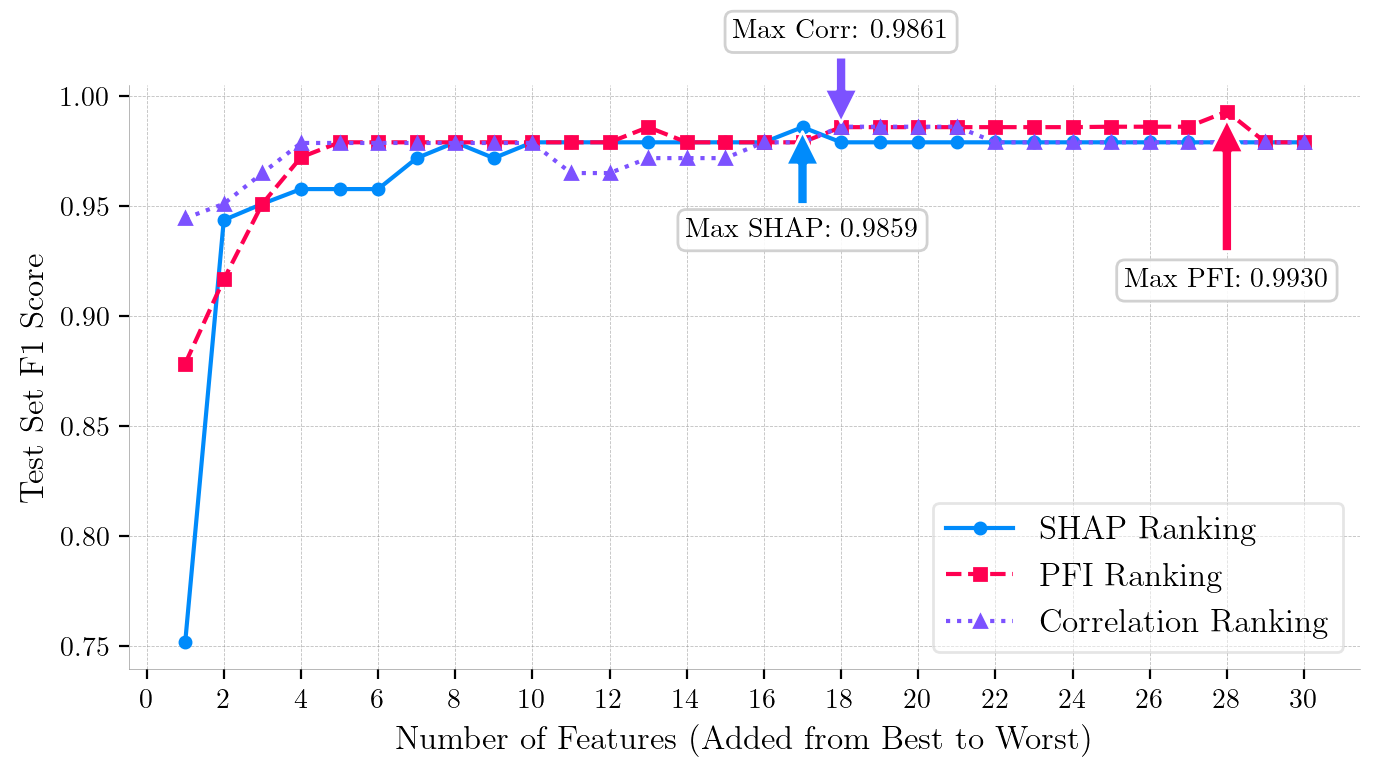

In [39]:
# ... [Previous imports and setup] ...

# 1. Extract Rankings
# PFI: Sort by 'PFI (mean F1 drop)' descending
pfi_ranking = df_importance.sort_values('PFI (mean F1 drop)', ascending=False)['Feature'].tolist()

# SHAP: Sort by 'SHAP (mean |val|)' descending
shap_ranking = df_importance.sort_values('SHAP (mean |val|)', ascending=False)['Feature'].tolist()

# --- NEW: Correlation Ranking ---
# Calculate absolute correlation between features and target (using training data)
# We temporarily combine X_train and y_train to easily calculate correlations
corr_df = X_train.copy()
corr_df['target'] = y_train
corr_ranking = corr_df.corr()['target'].abs().sort_values(ascending=False).drop('target').index.tolist()

# 2. Define Evaluation Function (Same as before)
def evaluate_feature_ranking(ranking, X_train, y_train, X_test, y_test, name):
    scores = []
    num_features = []
    
    print(f"Evaluating {name} ranking...")
    
    for k in range(1, len(ranking) + 1):
        top_k_features = ranking[:k]
        
        X_tr_sub = X_train[top_k_features]
        X_te_sub = X_test[top_k_features]
        
        lr_sub = LogisticRegression(max_iter=5000, random_state=42)
        lr_sub.fit(X_tr_sub, y_train)
        
        y_pred = lr_sub.predict(X_te_sub)
        score = f1_score(y_test, y_pred)
        
        scores.append(score)
        num_features.append(k)
        
    return num_features, scores

# 3. Run Evaluations
ns_shap, scores_shap = evaluate_feature_ranking(shap_ranking, X_train_scaled, y_train, X_test_scaled, y_test, "SHAP")
ns_pfi, scores_pfi = evaluate_feature_ranking(pfi_ranking, X_train_scaled, y_train, X_test_scaled, y_test, "PFI")
# --- NEW: Run Evaluation for Correlation ---
ns_corr, scores_corr = evaluate_feature_ranking(corr_ranking, X_train_scaled, y_train, X_test_scaled, y_test, "Correlation")


# 4. Plot Results
plt.figure(figsize=(7, 4))

shap_blue = "#008BFB"
shap_red = "#FF0051"
shap_purple = "#7C52FF"

# Plot SHAP Curve
plt.plot(ns_shap, scores_shap, marker='o', linestyle='-', color=shap_blue, label='SHAP Ranking', markersize=4)

# Plot PFI Curve
plt.plot(ns_pfi, scores_pfi, marker='s', linestyle='--', color=shap_red, label='PFI Ranking', markersize=4)

# --- NEW: Plot Correlation Curve ---
plt.plot(ns_corr, scores_corr, marker='^', linestyle='dotted', color=shap_purple, label='Correlation Ranking', markersize=4)


# Formatting
plt.xlabel('Number of Features (Added from Best to Worst)', fontsize=12)
plt.ylabel('Test Set F1 Score', fontsize=12)
plt.xticks(range(0, 31, 2))
#plt.xticks(range(1, len(X.columns)+1, 2)) # Optional: Adjust ticks if crowded
plt.legend(loc='lower right', fontsize=12)
#plt.grid(True)

# Annotate Max F1 for each method
max_shap_idx = scores_shap.index(max(scores_shap))
max_pfi_idx = scores_pfi.index(max(scores_pfi))
max_corr_idx = scores_corr.index(max(scores_corr))

legend_box = dict(boxstyle="round,pad=0.3", fc="white", ec="0.8", alpha=0.9)

# SHAP Annotation
plt.annotate(
    f'Max SHAP: {scores_shap[max_shap_idx]:.4f}',
    xy=(ns_shap[max_shap_idx], scores_shap[max_shap_idx]),
    xytext=(ns_shap[max_shap_idx], scores_shap[max_shap_idx] - 0.05),
    ha='center',
    arrowprops=dict(facecolor=shap_blue, edgecolor='white', shrink=0.05),
    bbox=legend_box
)

# PFI Annotation
plt.annotate(
    f'Max PFI: {scores_pfi[max_pfi_idx]:.4f}',
    xy=(ns_pfi[max_pfi_idx], scores_pfi[max_pfi_idx]),
    xytext=(ns_pfi[max_pfi_idx], scores_pfi[max_pfi_idx] - 0.08),
    ha='center',
    arrowprops=dict(facecolor=shap_red, edgecolor="white", shrink=0.05),
    bbox=legend_box
)

# --- NEW: Correlation Annotation ---
plt.annotate(
    f'Max Corr: {scores_corr[max_corr_idx]:.4f}',
    xy=(ns_corr[max_corr_idx], scores_corr[max_corr_idx]),
    xytext=(ns_corr[max_corr_idx], scores_corr[max_corr_idx] + 0.04), # Moved up to avoid overlap
    ha='center',
    arrowprops=dict(facecolor=shap_purple, edgecolor='white', shrink=0.05),
    bbox=legend_box
)

plt.tight_layout()
plt.show()

## Removing best features one-by-one

Running Ablation (Necessity) on SHAP...
Running Ablation (Necessity) on PFI...
Running Ablation (Necessity) on Correlation...


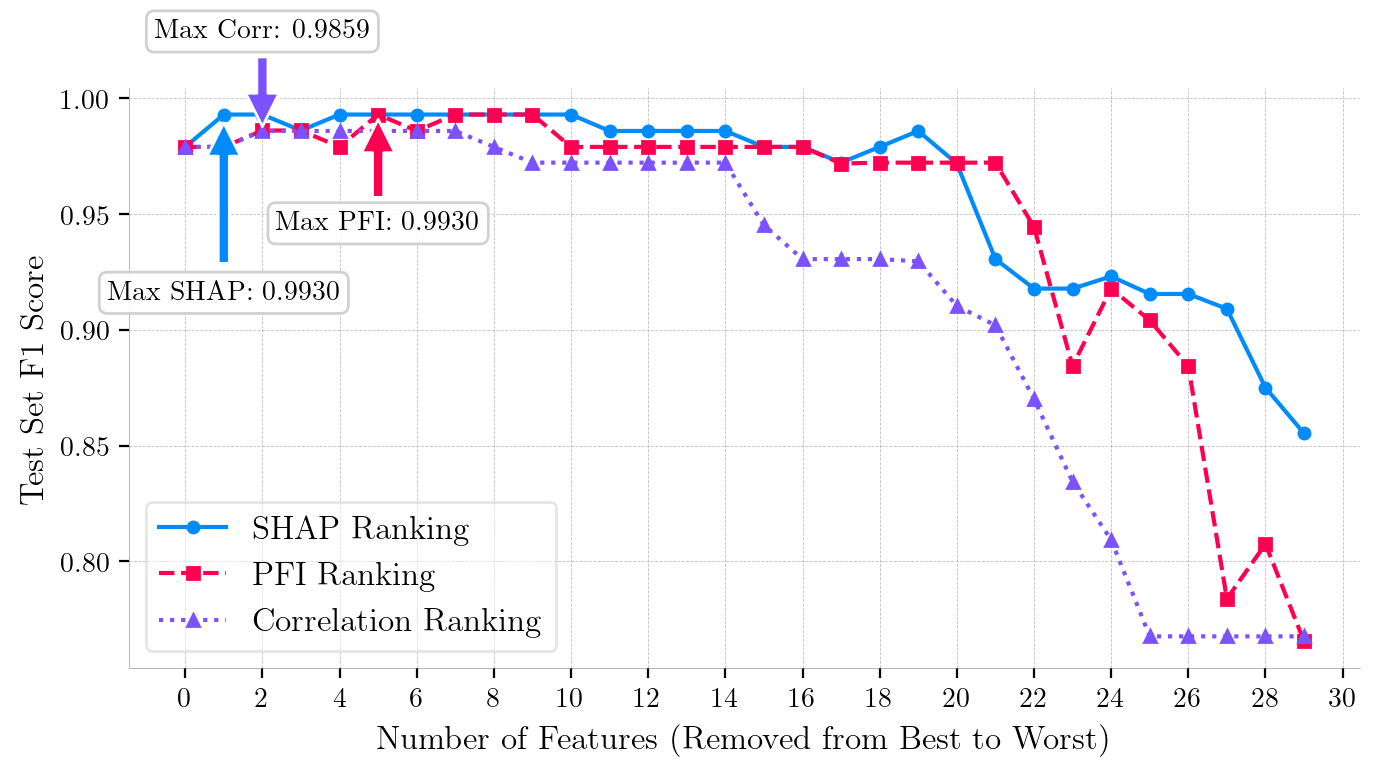

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np

# ... [Assume Imports, Data Loading, and Ranking Extraction are done as above] ...

# ---------------------------------------------------------
# EXPERIMENT 4: ABLATION CURVE (NECESSITY TEST)
# Method: Iteratively remove the *Best* features to test redundancy
# ---------------------------------------------------------

def evaluate_ablation_necessity(ranking, X_train, y_train, X_test, y_test, name):
    scores = []
    num_removed = []
    
    print(f"Running Ablation (Necessity) on {name}...")
    
    # We range from removing 0 features (full model) to removing N-1 features (leaving only the worst one)
    # We stop before removing all features to avoid empty input errors
    max_remove = len(ranking) 
    
    for k in range(max_remove):
        # LOGIC: Slice from k to the end. 
        # k=0: use all features (ranking[0:])
        # k=1: remove top 1 (ranking[1:])
        # k=5: remove top 5 (ranking[5:])
        features_to_keep = ranking[k:]
        
        # If we have no features left, break or handle (though loop limit handles this)
        if not features_to_keep:
            break

        X_tr_sub = X_train[features_to_keep]
        X_te_sub = X_test[features_to_keep]
        
        # Train
        lr_sub = LogisticRegression(max_iter=5000, random_state=42)
        lr_sub.fit(X_tr_sub, y_train)
        
        # Evaluate
        y_pred = lr_sub.predict(X_te_sub)
        score = f1_score(y_test, y_pred)
        
        scores.append(score)
        num_removed.append(k)
        
    return num_removed, scores

# 1. Run Evaluations
# Note: We reuse the SHAP, PFI, and Corr rankings from your previous code
nr_shap, scores_shap_ablation = evaluate_ablation_necessity(shap_ranking, X_train_scaled, y_train, X_test_scaled, y_test, "SHAP")
nr_pfi, scores_pfi_ablation = evaluate_ablation_necessity(pfi_ranking, X_train_scaled, y_train, X_test_scaled, y_test, "PFI")
nr_corr, scores_corr_ablation = evaluate_ablation_necessity(corr_ranking, X_train_scaled, y_train, X_test_scaled, y_test, "Correlation")

# 2. Plot Results
plt.figure(figsize=(7, 4))

shap_blue = "#008BFB"
shap_red = "#FF0051"
shap_purple = "#7C52FF"

# Plot SHAP Ablation
plt.plot(nr_shap, scores_shap_ablation, marker='o', linestyle='-', color=shap_blue, label='SHAP Ranking', markersize=4)

# Plot PFI Ablation
plt.plot(nr_pfi, scores_pfi_ablation, marker='s', linestyle='--', color=shap_red, label='PFI Ranking', markersize=4)

# Plot Correlation Ablation
plt.plot(nr_corr, scores_corr_ablation, marker='^', linestyle='dotted', color=shap_purple, label='Correlation Ranking', markersize=4)

# 3. Formatting
#plt.title("Necessity Test: Impact of Removing Top Features", fontsize=14)
plt.xlabel('Number of Features (Removed from Best to Worst)', fontsize=12)
plt.ylabel('Test Set F1 Score', fontsize=12)

# X-Ticks: dynamic based on feature count
plt.xticks(range(0, len(shap_ranking)+1, 2))
plt.legend(loc='lower left', fontsize=12)
#plt.grid(True, linestyle=':', alpha=0.6)

# Annotate Max F1 for each method
max_shap_ablation_idx = scores_shap_ablation.index(max(scores_shap_ablation))
max_pfi_ablation_idx = scores_pfi_ablation.index(max(scores_pfi_ablation))
max_corr_ablation_idx = scores_corr_ablation.index(max(scores_corr_ablation))

# SHAP Annotation
plt.annotate(
    f'Max SHAP: {scores_shap_ablation[max_shap_ablation_idx]:.4f}',
    xy=(nr_shap[max_shap_ablation_idx], scores_shap_ablation[max_shap_ablation_idx]),
    xytext=(nr_shap[max_shap_ablation_idx], scores_shap_ablation[max_shap_ablation_idx] - 0.08),
    ha='center',
    arrowprops=dict(facecolor=shap_blue, edgecolor='white', shrink=0.05),
    bbox=legend_box
)

# PFI Annotation
plt.annotate(
    f'Max PFI: {scores_pfi_ablation[max_pfi_ablation_idx]:.4f}',
    xy=(nr_pfi[max_pfi_ablation_idx], scores_pfi_ablation[max_pfi_ablation_idx]),
    xytext=(nr_pfi[max_pfi_ablation_idx], scores_pfi_ablation[max_pfi_ablation_idx] - 0.05),
    ha='center',
    arrowprops=dict(facecolor=shap_red, edgecolor='white', shrink=0.05),
    bbox=legend_box
)

# --- NEW: Correlation Annotation ---
plt.annotate(
    f'Max Corr: {scores_corr_ablation[max_corr_ablation_idx]:.4f}',
    xy=(nr_corr[max_corr_ablation_idx], scores_corr_ablation[max_corr_ablation_idx]),
    xytext=(nr_corr[max_corr_ablation_idx], scores_corr_ablation[max_corr_ablation_idx] + 0.04), # Moved up to avoid overlap
    ha='center',
    arrowprops=dict(facecolor=shap_purple, edgecolor='white', shrink=0.05),
    bbox=legend_box
)

plt.tight_layout()
plt.show()

In [17]:
# find maximum value of scores_shap_ablation
max(scores_shap_ablation)

0.993006993006993

# XGBoost

Training XGBoost...
Baseline F1 Score on Test Set: 0.9650
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        43
           1       0.96      0.97      0.97        71

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

Computing SHAP values...
Computing PFI (scoring='f1')...


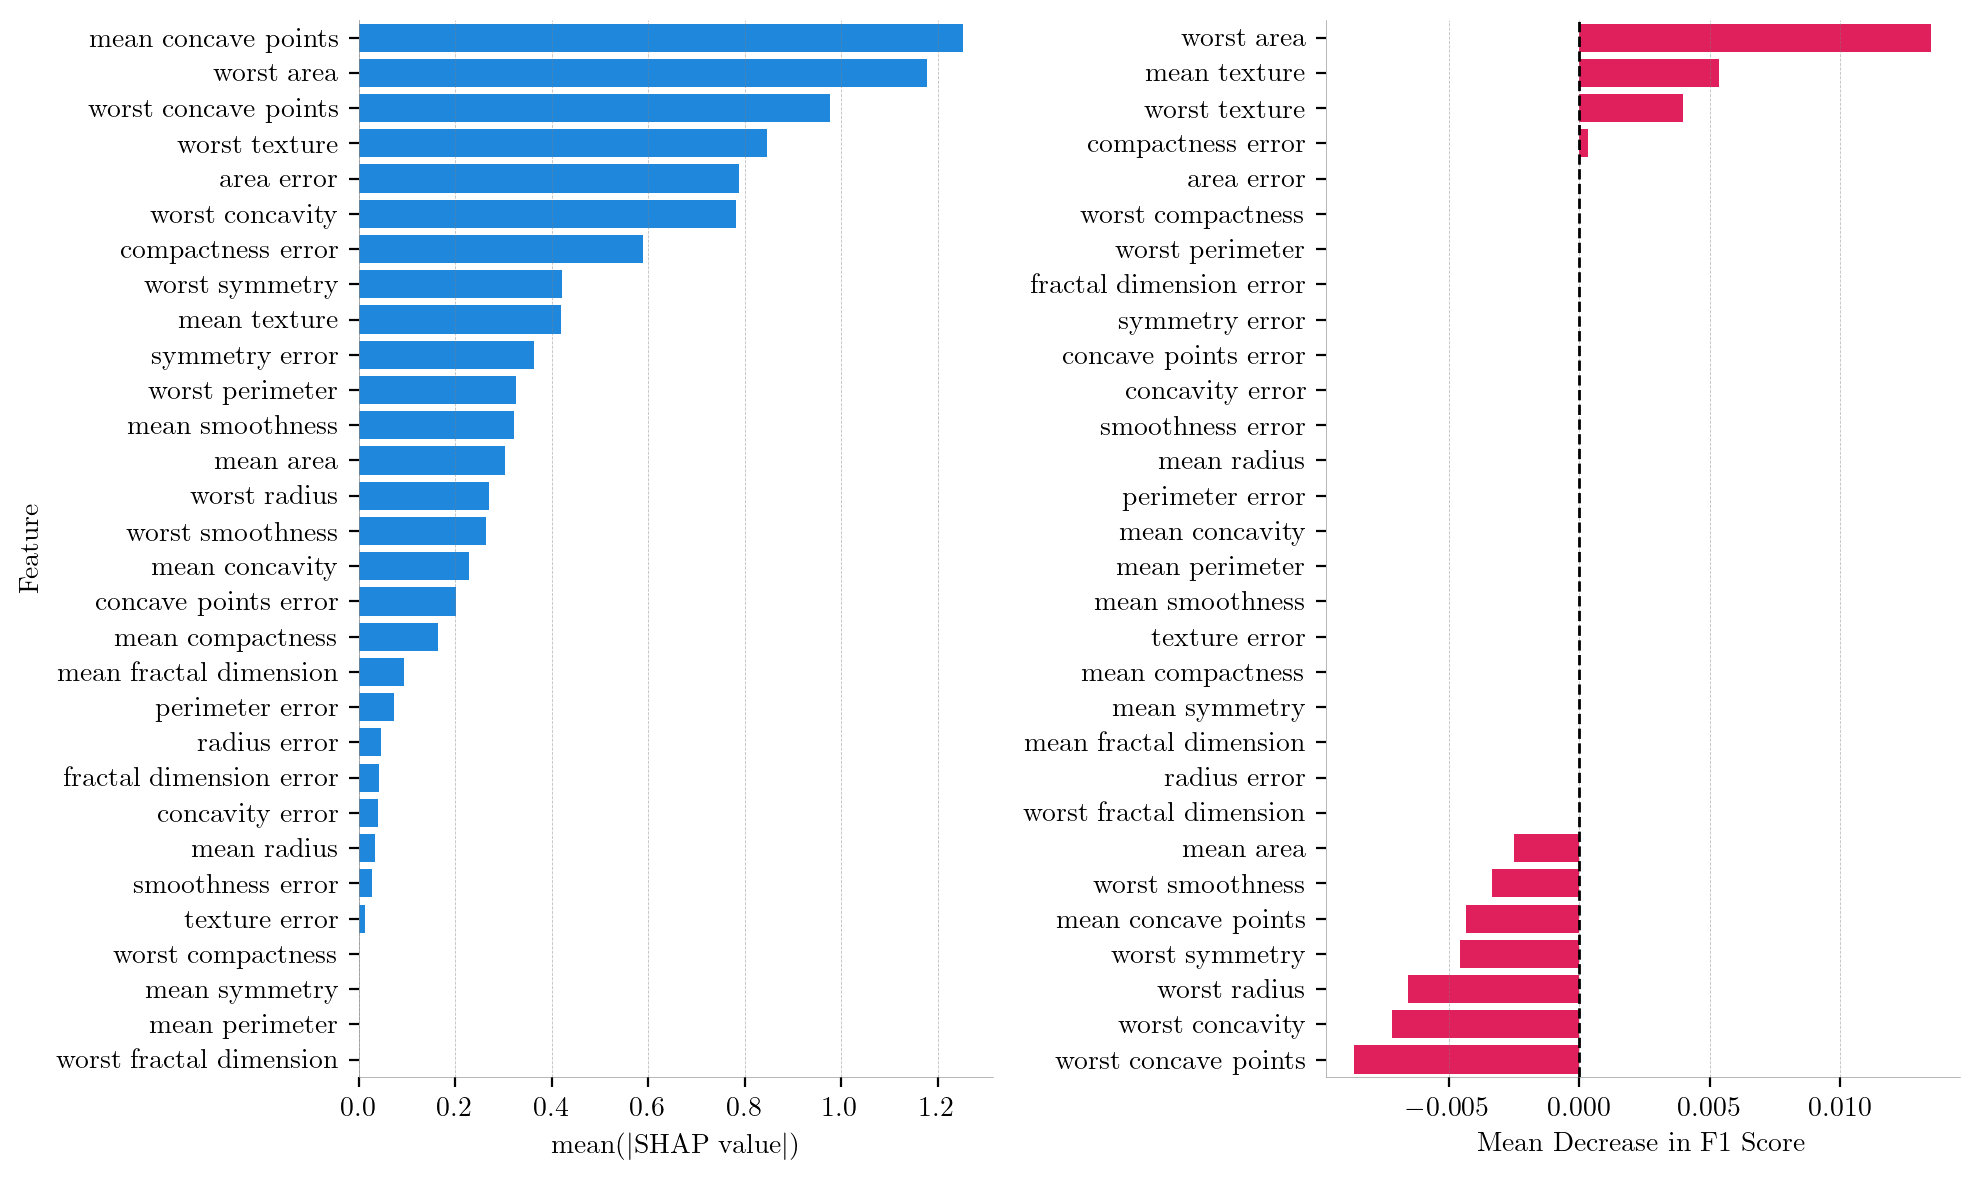

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score

from xgboost import XGBClassifier   # <-- NEW IMPORT

# 1. Prepare Data
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# (Optional) Scaling — not needed for trees, but harmless to keep for consistency
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

# 2. Train XGBoost
print("Training XGBoost...")
xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
xgb.fit(X_train_scaled, y_train)

# Baseline F1
y_pred = xgb.predict(X_test_scaled)
baseline_f1 = f1_score(y_test, y_pred)
print(f"Baseline F1 Score on Test Set: {baseline_f1:.4f}")
print(classification_report(y_test, y_pred))

# 3. SHAP Feature Importance
print("Computing SHAP values...")
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test_scaled)

# Handle binary output format
if isinstance(shap_values, list):
    shap_summary = np.abs(shap_values[1]).mean(axis=0)
else:
    shap_summary = np.abs(shap_values).mean(axis=0)

# 4. Permutation Importance
print("Computing PFI (scoring='f1')...")
pfi = permutation_importance(
    xgb,
    X_test_scaled,
    y_test,
    n_repeats=30,
    random_state=42,
    scoring="f1"
)
pfi_summary = pfi.importances_mean

# 5. Organize
df_importance = pd.DataFrame({
    'Feature': X.columns,
    'SHAP (mean |val|)': shap_summary,
    'PFI (mean F1 drop)': pfi_summary
})

df_shap_sorted = df_importance.sort_values('SHAP (mean |val|)', ascending=False)
df_pfi_sorted = df_importance.sort_values('PFI (mean F1 drop)', ascending=False)

# 6. Visualization
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

shap_blue = "#008BFB"
shap_red = "#FF0051"

# SHAP
sns.barplot(
    data=df_shap_sorted, 
    x='SHAP (mean |val|)', 
    y='Feature', 
    ax=axes[0], 
    color=shap_blue
)
axes[0].set_xlabel('mean($|$SHAP value$|$)')

# PFI
sns.barplot(
    data=df_pfi_sorted, 
    x='PFI (mean F1 drop)', 
    y='Feature', 
    ax=axes[1], 
    color=shap_red
)
axes[1].set_xlabel('Mean Decrease in F1 Score')
axes[1].set_ylabel('')
axes[1].axvline(0, color='black', linewidth=1, linestyle='--')

plt.tight_layout()
plt.show()

# Runtime and Memory

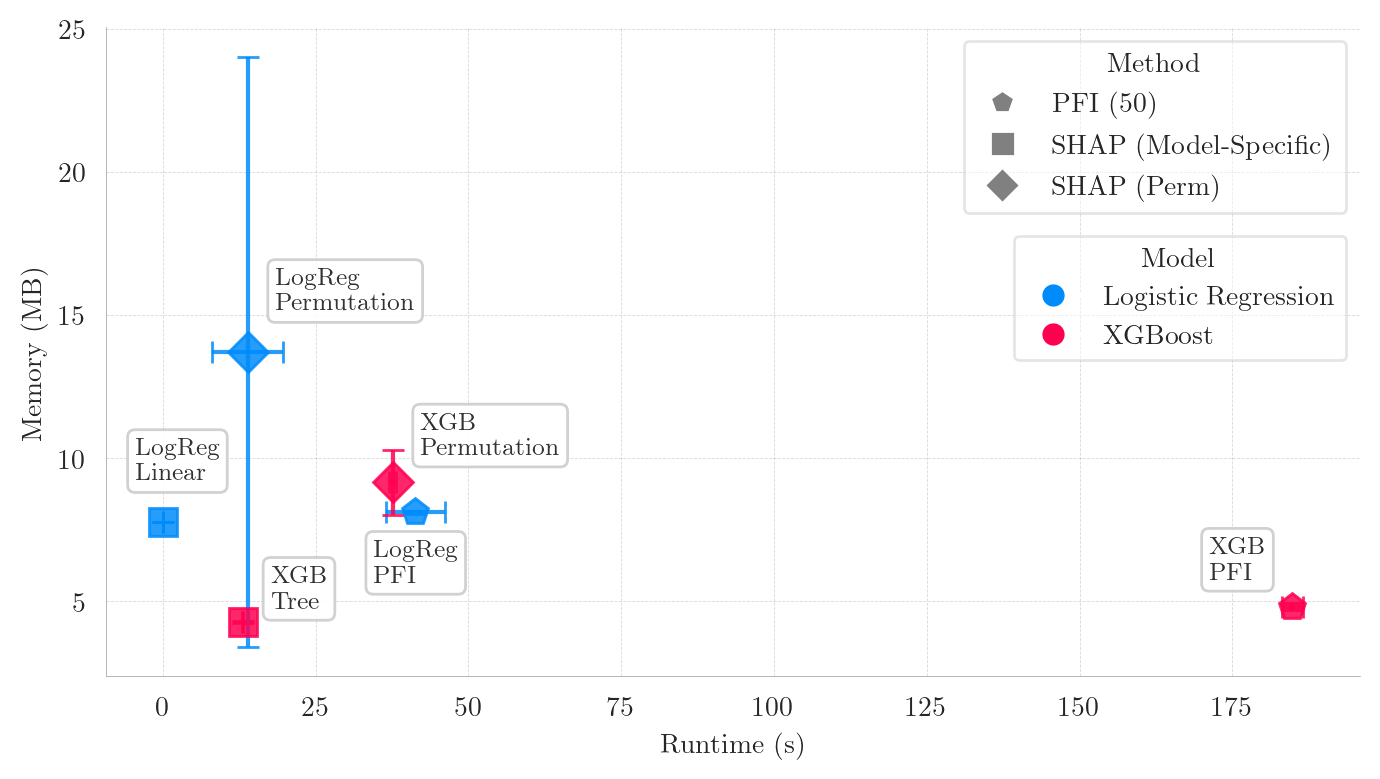

In [90]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd

# --- 1. CONFIGURATION SECTION ---
label_config = {
    ("PFI (50)", "LogReg"):       (-15, -25, "LogReg\nPFI"),
    ("PFI (50)", "XGB"):          (-30, 10, "XGB\nPFI"),
    ("SHAP (Aware)", "LogReg"):   (-10, 15, "LogReg\nLinear"),
    ("SHAP (Aware)", "XGB"):      (10, 5, "XGB\nTree"),
    ("SHAP (Perm)", "LogReg"):    (10, 15, "LogReg\nPermutation"),
    ("SHAP (Perm)", "XGB"):       (10, 10, "XGB\nPermutation")
}

# --- 2. DATA SETUP ---
data = {
    'Method': ['PFI (50)', 'PFI (50)', 'SHAP (Aware)', 'SHAP (Aware)', 'SHAP (Perm)', 'SHAP (Perm)'],
    'Model': ['LogReg', 'XGB', 'LogReg', 'XGB', 'LogReg', 'XGB'],
    'Time_mean': [41.2679, 184.8165, 0.0082, 13.0883, 13.8522, 37.5722],
    'Time_std': [4.8295, 1.7207, 0.0006, 0.0859, 5.8404, 0.5693],
    'Mem_mean': [8.1020, 4.8122, 7.7750, 4.2818, 13.7158, 9.1524],
    'Mem_std': [0.0588, 0.1360, 0.0069, 0.0438, 10.3036, 1.1439]
}
df_results = pd.DataFrame(data)

colors = {"LogReg": shap_blue, "XGB": shap_red}
markers = {"PFI (50)": "p", "SHAP (Aware)": "s", "SHAP (Perm)": "D"}

# --- 3. PLOTTING LOGIC ---
plt.figure(figsize=(7, 4))

for _, row in df_results.iterrows():
    plt.errorbar(
        row["Time_mean"],
        row["Mem_mean"],
        xerr=row["Time_std"],
        yerr=row["Mem_std"],
        fmt=markers[row["Method"]],
        color=colors[row["Model"]],
        markersize=10,
        capsize=4,
        alpha=0.85
    )

    key = (row["Method"], row["Model"])
    x_off, y_off, label_text = label_config.get(key, (5, 5, row["Method"]))

    plt.annotate(
        label_text,
        xy=(row["Time_mean"], row["Mem_mean"]),
        xytext=(x_off, y_off),
        textcoords='offset points',
        fontsize=9,
        alpha=0.8,
        color='black',
        bbox=legend_box
    )

plt.xlabel("Runtime (s)")
plt.ylabel("Memory (MB)")
#plt.title("Runtime vs Memory Tradeoff\n(mean ± std over 5 runs)")
plt.grid(True, alpha=0.3)

# --- 4. DUAL LEGEND SETUP ---

# Legend 1: Method (Shapes)
legend_elements_method = [
    Line2D([0], [0], marker='p', color='w', label='PFI (50)', markerfacecolor='gray', markersize=9),
    Line2D([0], [0], marker='s', color='w', label='SHAP (Model-Specific)', markerfacecolor='gray', markersize=9),
    Line2D([0], [0], marker='D', color='w', label='SHAP (Perm)', markerfacecolor='gray', markersize=9),
]

# Create the first legend
first_legend = plt.legend(
    handles=legend_elements_method, 
    title="Method", 
    loc="upper right", 
    bbox_to_anchor=(1, 1),
    fontsize=10
)

# Add the first legend manually to the plot
plt.gca().add_artist(first_legend)

# Legend 2: Model (Colors)
legend_elements_model = [
    Line2D([0], [0], marker='o', color='w', label='Logistic Regression', markerfacecolor=colors["LogReg"], markersize=9),
    Line2D([0], [0], marker='o', color='w', label='XGBoost', markerfacecolor=colors["XGB"], markersize=9),
]

# Create the second legend (stacked below the first one)
plt.legend(
    handles=legend_elements_model, 
    title="Model", 
    loc="upper right", 
    bbox_to_anchor=(1, 0.7), # Lower the y-coordinate to stack it
    fontsize=10
)

plt.tight_layout()
plt.show()

## spearman

BEFORE - Full Model F1 Score: 0.9790
Reduced features from 30 to 11
Selected Representatives: ['smoothness error', 'symmetry error', 'worst fractal dimension', 'worst smoothness', 'worst symmetry', 'worst texture', 'texture error', 'worst concave points', 'concave points error', 'worst perimeter', 'radius error']
AFTER - Reduced Model F1 Score: 0.9790


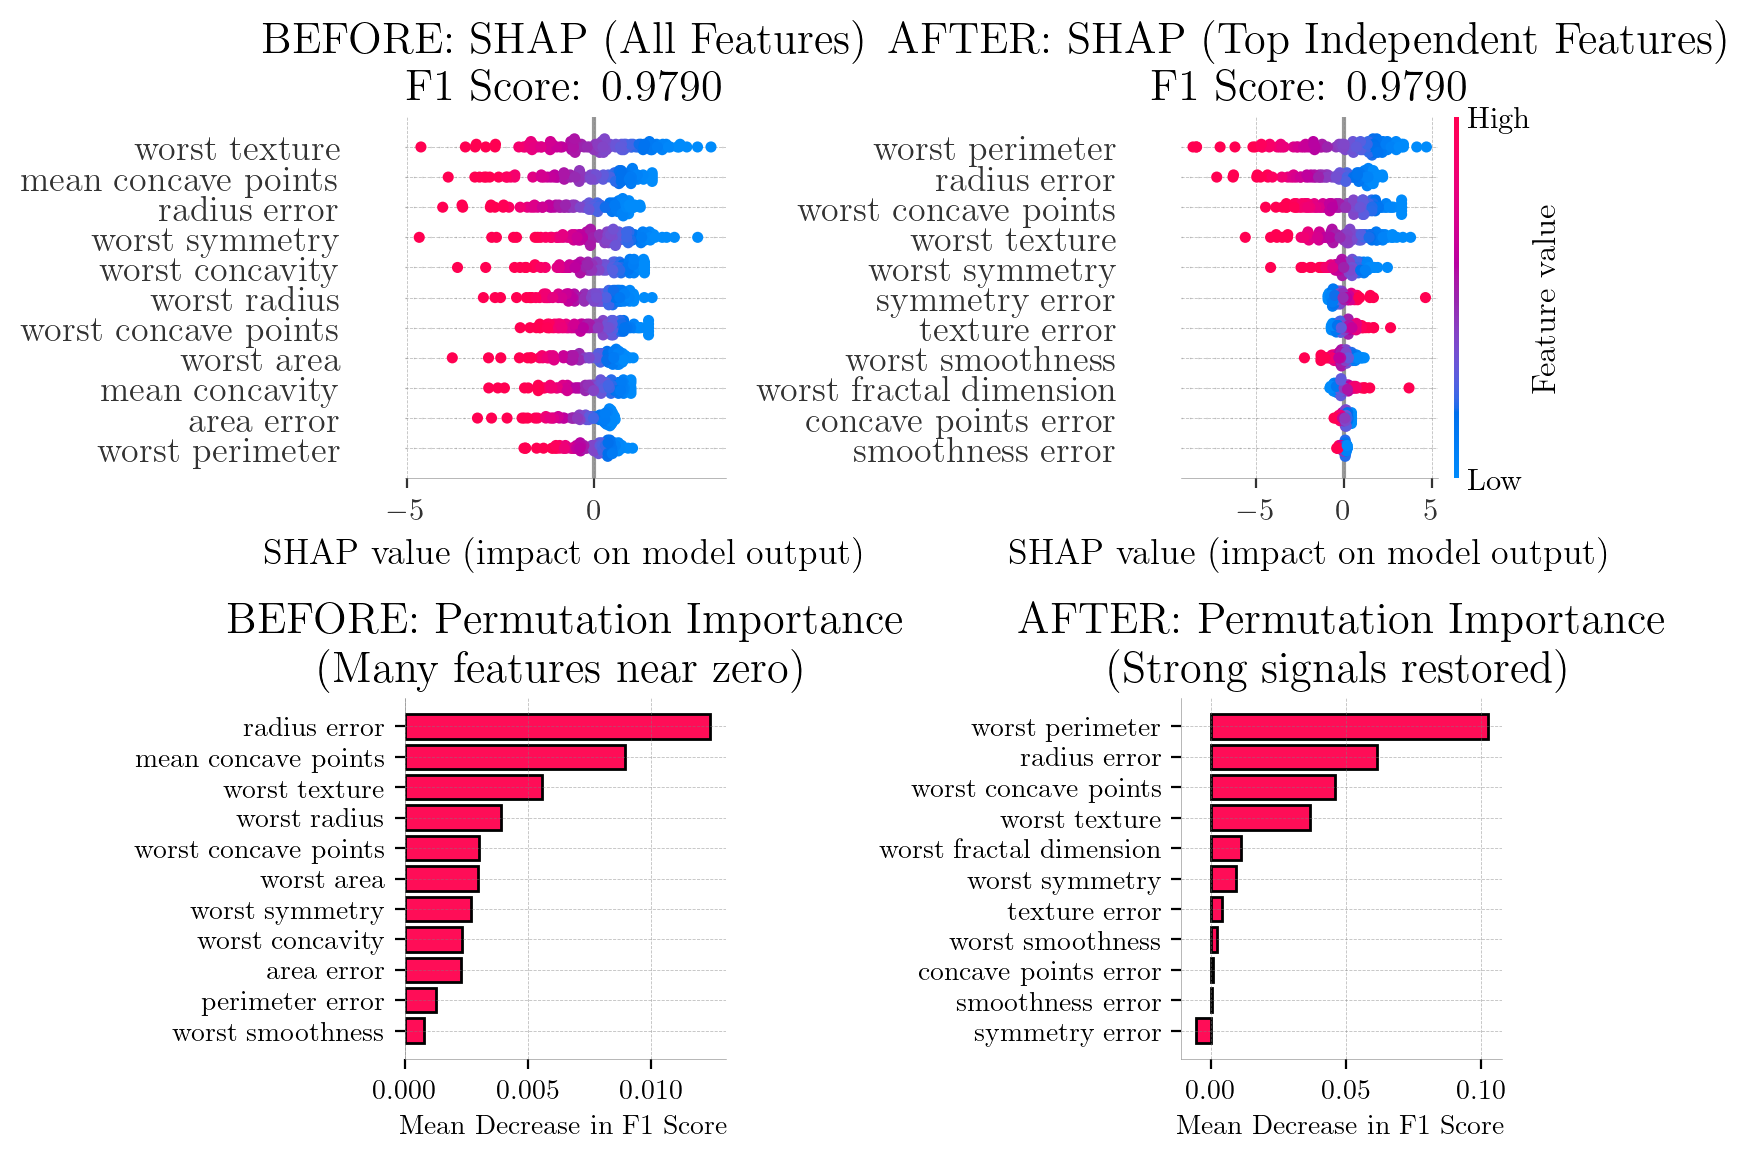

In [22]:
import pandas as pd
import numpy as np
import shap
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score  # <--- Imported for scoring

# --- 1. Load Data ---
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale data (CRITICAL for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

# ==========================================
# PHASE A: BEFORE (Original Correlated Data)
# ==========================================
model_full = LogisticRegression(max_iter=1000, random_state=42)
model_full.fit(X_train_scaled, y_train)

# --- NEW: Calculate & Print F1 Score (Before) ---
y_pred_full = model_full.predict(X_test_scaled)
f1_full = f1_score(y_test, y_pred_full)
print(f"BEFORE - Full Model F1 Score: {f1_full:.4f}")

# SHAP (Full)
explainer_full = shap.LinearExplainer(model_full, X_train_scaled)
shap_values_full = explainer_full.shap_values(X_test_scaled)

# PFI (Full)
pfi_full = permutation_importance(model_full, X_test_scaled, y_test, n_repeats=30, random_state=42, scoring='f1')

# ==========================================
# PHASE B: SOLVING CORRELATION (Clustering)
# ==========================================
# 1. Compute Spearman Correlation (on training data only to prevent leakage)
corr = X_train_scaled.corr(method='spearman')

# 2. Hierarchical Clustering
distance_matrix = 1 - np.abs(corr)
linkage_matrix = sch.linkage(squareform(distance_matrix), method='ward')

# 3. Form Clusters (Threshold t=0.5)
cluster_ids = sch.fcluster(linkage_matrix, t=0.5, criterion='distance')

# 4. Select Representatives
X_train_w_target = X_train_scaled.copy()
X_train_w_target['target'] = y_train
corrs_with_target = X_train_w_target.corr().abs()['target']

selected_features = []
for cluster_id in set(cluster_ids):
    features_in_cluster = X.columns[cluster_ids == cluster_id]
    best_feature = corrs_with_target[features_in_cluster].idxmax()
    selected_features.append(best_feature)

print(f"Reduced features from {X.shape[1]} to {len(selected_features)}")
print("Selected Representatives:", selected_features)

# ==========================================
# PHASE C: AFTER (Reduced Data)
# ==========================================
X_train_reduced = X_train_scaled[selected_features]
X_test_reduced = X_test_scaled[selected_features]

model_reduced = LogisticRegression(max_iter=1000, random_state=42)
model_reduced.fit(X_train_reduced, y_train)

# --- NEW: Calculate & Print F1 Score (After) ---
y_pred_reduced = model_reduced.predict(X_test_reduced)
f1_reduced = f1_score(y_test, y_pred_reduced)
print(f"AFTER - Reduced Model F1 Score: {f1_reduced:.4f}")

# SHAP (Reduced)
explainer_reduced = shap.LinearExplainer(model_reduced, X_train_reduced)
shap_values_reduced = explainer_reduced.shap_values(X_test_reduced)

# PFI (Reduced)
pfi_reduced = permutation_importance(model_reduced, X_test_reduced, y_test, n_repeats=30, random_state=42, scoring='f1')

# ==========================================
# PHASE D: VISUALIZATION (Adjusted for Full View)
# ==========================================
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(25, 25))

# --- Row 1: SHAP Comparison ---
plt.sca(axes[0, 0])
plt.title(f"BEFORE: SHAP (All Features)\nF1 Score: {f1_full:.4f}", fontsize=16) # Added Score to Title
shap.summary_plot(shap_values_full, X_test_scaled, show=False, max_display=11, color_bar=False)

plt.sca(axes[0, 1])
plt.title(f"AFTER: SHAP (Top Independent Features)\nF1 Score: {f1_reduced:.4f}", fontsize=16) # Added Score to Title
shap.summary_plot(shap_values_reduced, X_test_reduced, show=False, max_display=11, color_bar=True)

# --- Row 2: PFI Comparison ---
def plot_pfi(pfi_result, feature_names, ax, title):
    # Sort all features
    indices = pfi_result.importances_mean.argsort()[::-1][:11]
    # Plot ALL features
    ax.barh(range(len(indices)), pfi_result.importances_mean[indices], color='#ff0d57', edgecolor='k')
    ax.set_yticks(range(len(indices)))
    ax.set_yticklabels(np.array(feature_names)[indices], fontsize=10)
    ax.invert_yaxis()
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Mean Decrease in F1 Score")

plot_pfi(pfi_full, X.columns, axes[1, 0], f"BEFORE: Permutation Importance\n(Many features near zero)")
plot_pfi(pfi_reduced, selected_features, axes[1, 1], f"AFTER: Permutation Importance\n(Strong signals restored)")

plt.tight_layout()
plt.show()

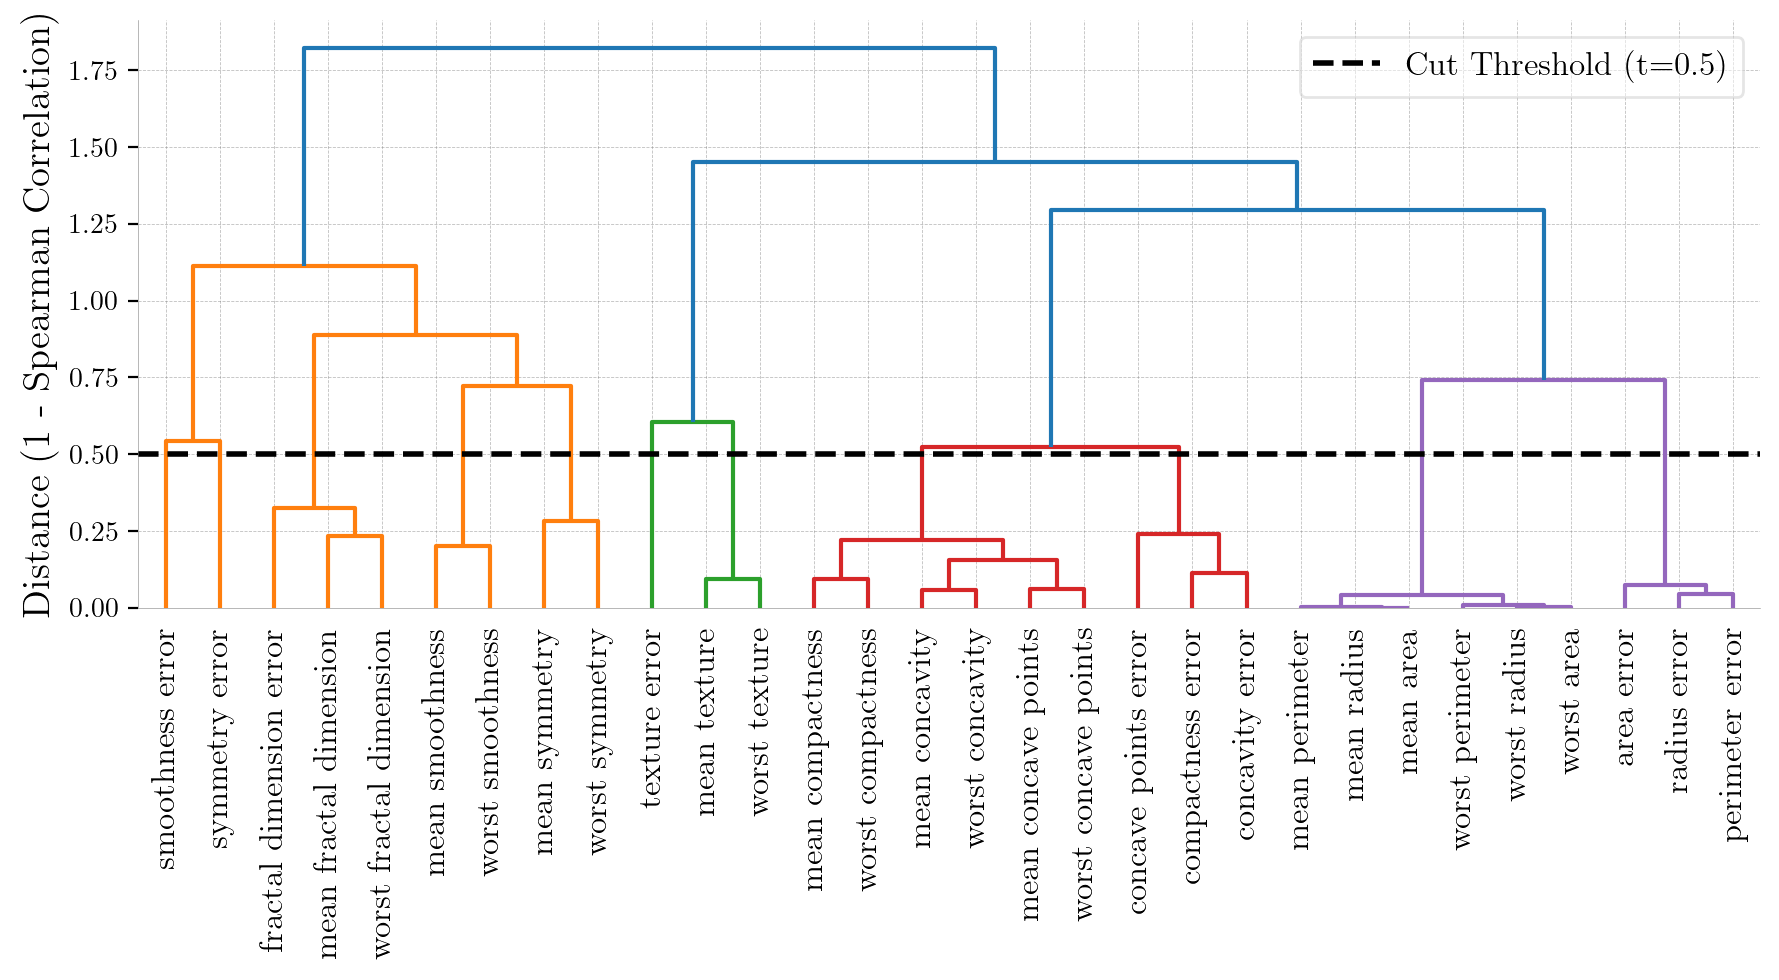

In [ ]:
# spearman
plt.figure(figsize=(9, 5))
#plt.title("Hierarchical Clustering Dendrogram\n(Visualizing Feature Redundancy)", fontsize=18)
sch.dendrogram(linkage_matrix, labels=X.columns, leaf_rotation=90, leaf_font_size=12)
plt.axhline(y=0.5, color='black', linestyle='--', linewidth=2, label='Cut Threshold (t=0.5)')
plt.ylabel("Distance (1 - Spearman Correlation)", fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

## pearson

BEFORE - Full Model Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        43
           1       0.97      0.99      0.98        71

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

Reduced features from 30 to 11
Selected Representatives: ['worst texture', 'radius error', 'worst perimeter', 'worst concave points', 'worst symmetry', 'worst smoothness', 'worst fractal dimension', 'concave points error', 'texture error', 'symmetry error', 'smoothness error']
AFTER - Reduced Model Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        43
           1       0.97      0.99      0.98        71

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97  

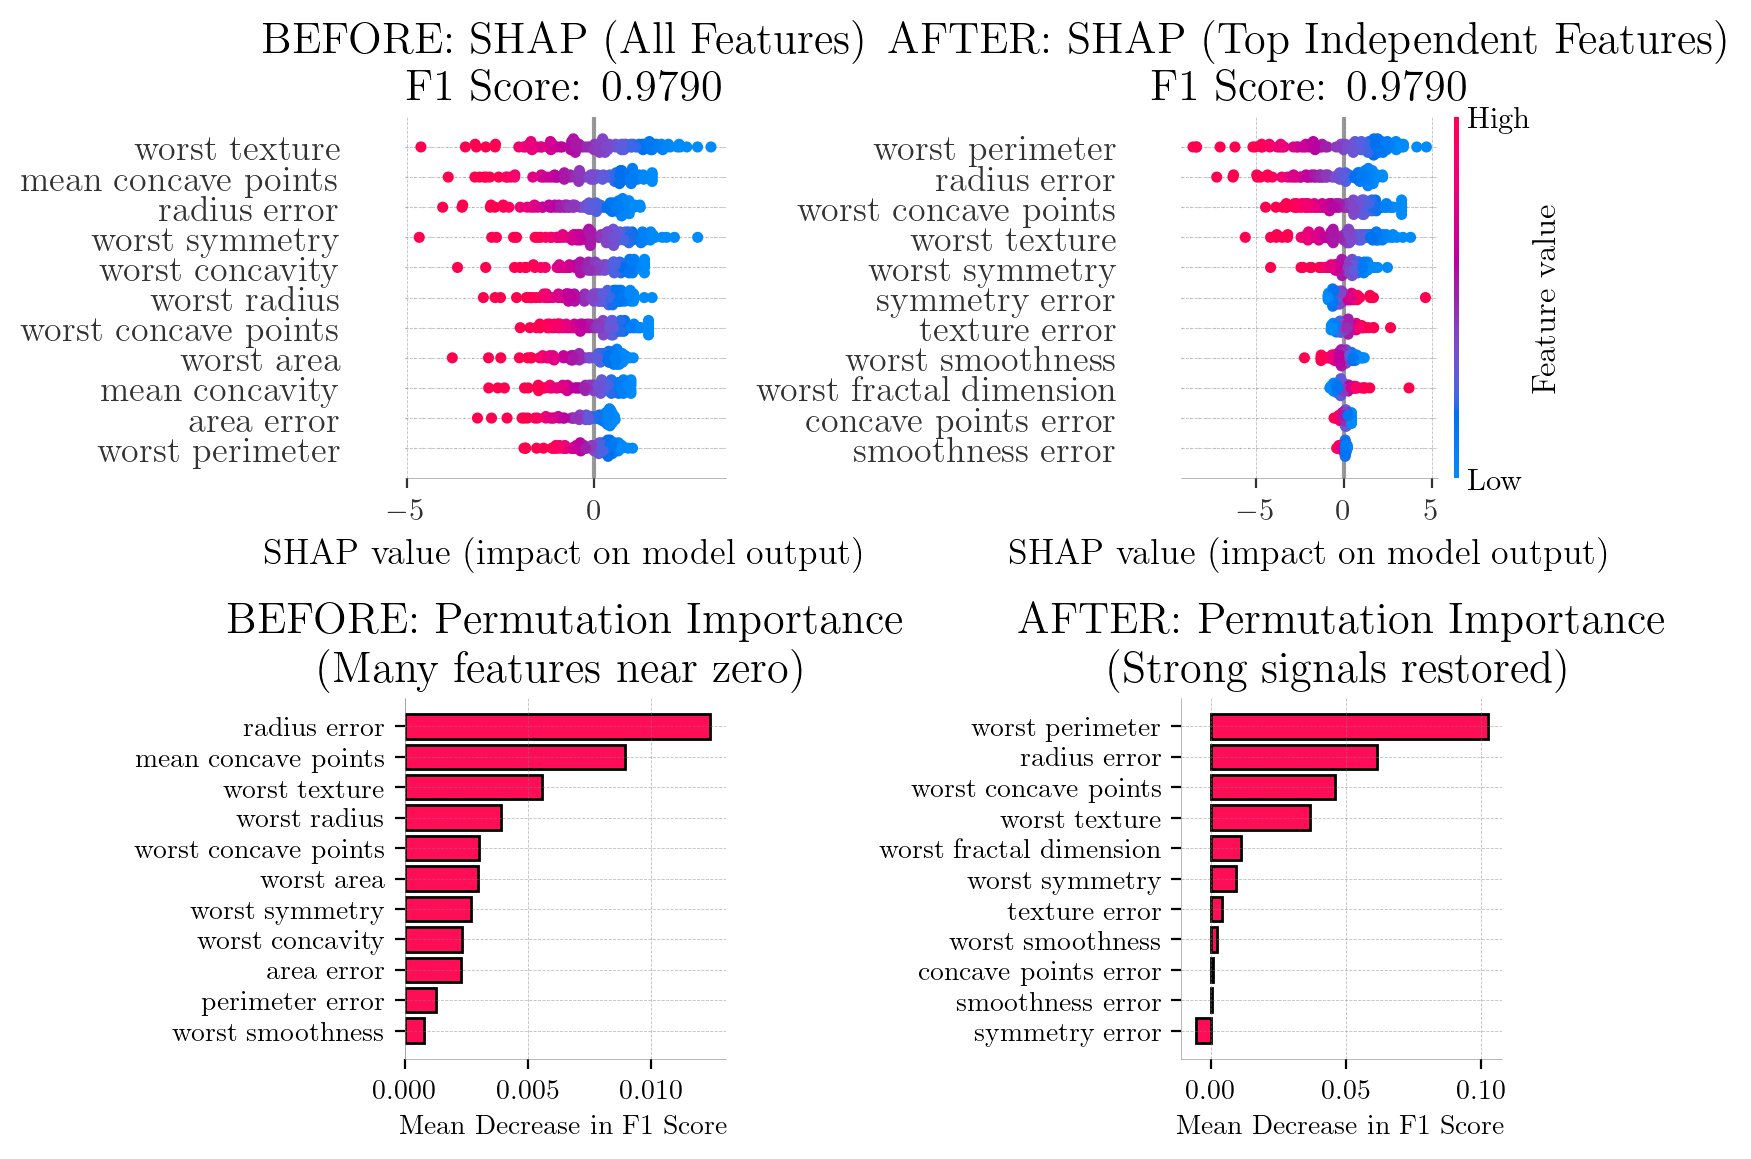

In [ ]:
import pandas as pd
import numpy as np
import shap
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score  # <--- Imported for scoring

# --- 1. Load Data ---
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale data (CRITICAL for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

# ==========================================
# PHASE A: BEFORE (Original Correlated Data)
# ==========================================
model_full = LogisticRegression(max_iter=1000, random_state=42)
model_full.fit(X_train_scaled, y_train)

# --- NEW: Calculate & Print F1 Score (Before) ---
y_pred_full = model_full.predict(X_test_scaled)
class_report_full = classification_report(y_test, y_pred_full)
f1_full = f1_score(y_test, y_pred_full)
print("BEFORE - Full Model Classification Report:")
print(class_report_full)
print(f"BEFORE - Full Model F1 Score: {f1_full:.4f}")
# SHAP (Full)
explainer_full = shap.LinearExplainer(model_full, X_train_scaled)
shap_values_full = explainer_full.shap_values(X_test_scaled)

# PFI (Full)
pfi_full = permutation_importance(model_full, X_test_scaled, y_test, n_repeats=30, random_state=42, scoring='f1')

# ==========================================
# PHASE B: SOLVING CORRELATION (Clustering)
# ==========================================
# 1. Compute Pearson Correlation (on training data only to prevent leakage)
corr = X_train_scaled.corr(method='pearson')

# 2. Hierarchical Clustering
distance_matrix = 1 - np.abs(corr)
linkage_matrix = sch.linkage(squareform(distance_matrix), method='ward')

# 3. Form Clusters (Threshold t=0.5)
cluster_ids = sch.fcluster(linkage_matrix, t=0.5, criterion='distance')

# 4. Select Representatives
X_train_w_target = X_train_scaled.copy()
X_train_w_target['target'] = y_train
corrs_with_target = X_train_w_target.corr().abs()['target']

selected_features = []
for cluster_id in set(cluster_ids):
    features_in_cluster = X.columns[cluster_ids == cluster_id]
    best_feature = corrs_with_target[features_in_cluster].idxmax()
    selected_features.append(best_feature)

print(f"Reduced features from {X.shape[1]} to {len(selected_features)}")
print("Selected Representatives:", selected_features)

# ==========================================
# PHASE C: AFTER (Reduced Data)
# ==========================================
X_train_reduced = X_train_scaled[selected_features]
X_test_reduced = X_test_scaled[selected_features]

model_reduced = LogisticRegression(max_iter=1000, random_state=42)
model_reduced.fit(X_train_reduced, y_train)

# --- NEW: Calculate & Print F1 Score (After) ---
y_pred_reduced = model_reduced.predict(X_test_reduced)
class_report_reduced = classification_report(y_test, y_pred_reduced)
f1_reduced = f1_score(y_test, y_pred_reduced)
print("AFTER - Reduced Model Classification Report:")
print(class_report_reduced)
print(f"AFTER - Reduced Model F1 Score: {f1_reduced:.4f}")
# SHAP (Reduced)
explainer_reduced = shap.LinearExplainer(model_reduced, X_train_reduced)
shap_values_reduced = explainer_reduced.shap_values(X_test_reduced)

# PFI (Reduced)
pfi_reduced = permutation_importance(model_reduced, X_test_reduced, y_test, n_repeats=30, random_state=42, scoring='f1')

# ==========================================
# PHASE D: VISUALIZATION (Adjusted for Full View)
# ==========================================
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(25, 25))

# --- Row 1: SHAP Comparison ---
plt.sca(axes[0, 0])
plt.title(f"BEFORE: SHAP (All Features)\nF1 Score: {f1_full:.4f}", fontsize=16) # Added Score to Title
shap.summary_plot(shap_values_full, X_test_scaled, show=False, max_display=11, color_bar=False)

plt.sca(axes[0, 1])
plt.title(f"AFTER: SHAP (Top Independent Features)\nF1 Score: {f1_reduced:.4f}", fontsize=16) # Added Score to Title
shap.summary_plot(shap_values_reduced, X_test_reduced, show=False, max_display=11, color_bar=True)

# --- Row 2: PFI Comparison ---
def plot_pfi(pfi_result, feature_names, ax, title):
    # Sort all features
    indices = pfi_result.importances_mean.argsort()[::-1][:11]
    # Plot ALL features
    ax.barh(range(len(indices)), pfi_result.importances_mean[indices], color='#ff0d57', edgecolor='k')
    ax.set_yticks(range(len(indices)))
    ax.set_yticklabels(np.array(feature_names)[indices], fontsize=10)
    ax.invert_yaxis()
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Mean Decrease in F1 Score")

plot_pfi(pfi_full, X.columns, axes[1, 0], f"BEFORE: Permutation Importance\n(Many features near zero)")
plot_pfi(pfi_reduced, selected_features, axes[1, 1], f"AFTER: Permutation Importance\n(Strong signals restored)")

plt.tight_layout()
plt.show()

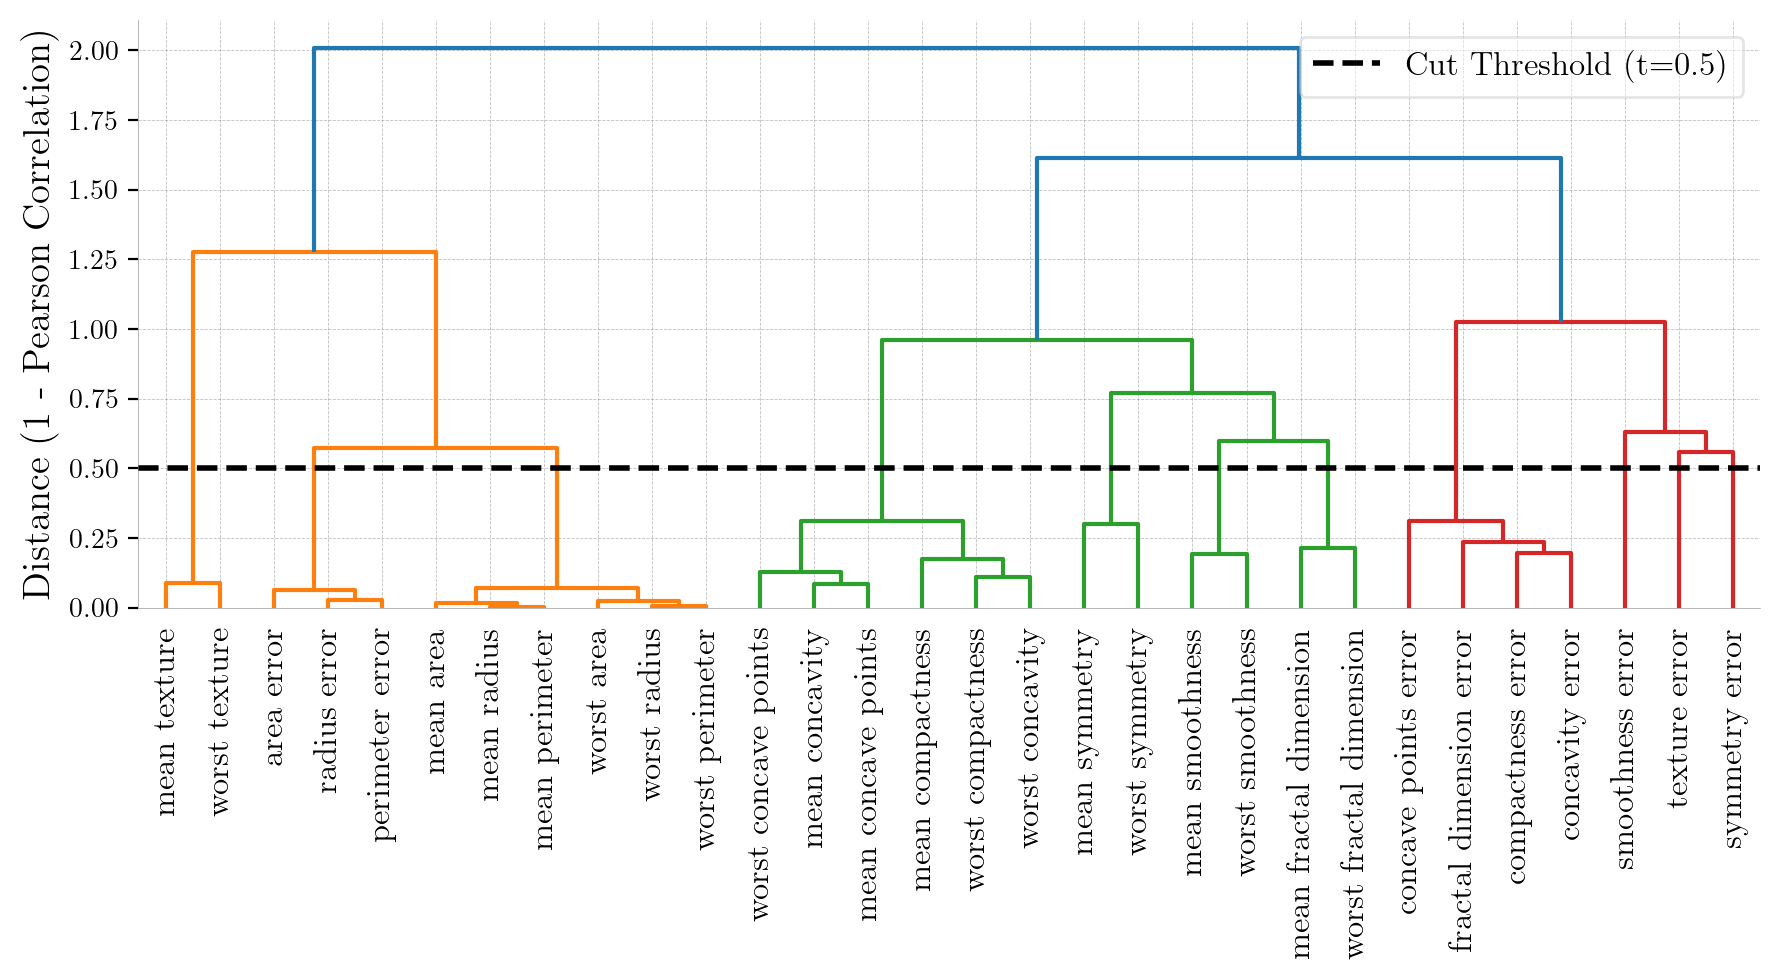

In [27]:
# pearson
plt.figure(figsize=(9, 5))
#plt.title("Hierarchical Clustering Dendrogram\n(Visualizing Feature Redundancy)", fontsize=18)
sch.dendrogram(linkage_matrix, labels=X.columns, leaf_rotation=90, leaf_font_size=12)
plt.axhline(y=0.5, color='black', linestyle='--', linewidth=2, label='Cut Threshold (t=0.5)')
plt.ylabel("Distance (1 - Pearson Correlation)", fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

- **Pearson:** ['worst texture', 'radius error', 'worst perimeter', 'worst concave points', 'worst symmetry', 'worst smoothness', 'worst fractal dimension', 'concave points error', 'texture error', 'symmetry error', 'smoothness error']

- **Spearman:** ['smoothness error', 'symmetry error', 'worst fractal dimension', 'worst smoothness', 'worst symmetry', 'worst texture', 'texture error', 'worst concave points', 'concave points error', 'worst perimeter', 'radius error']

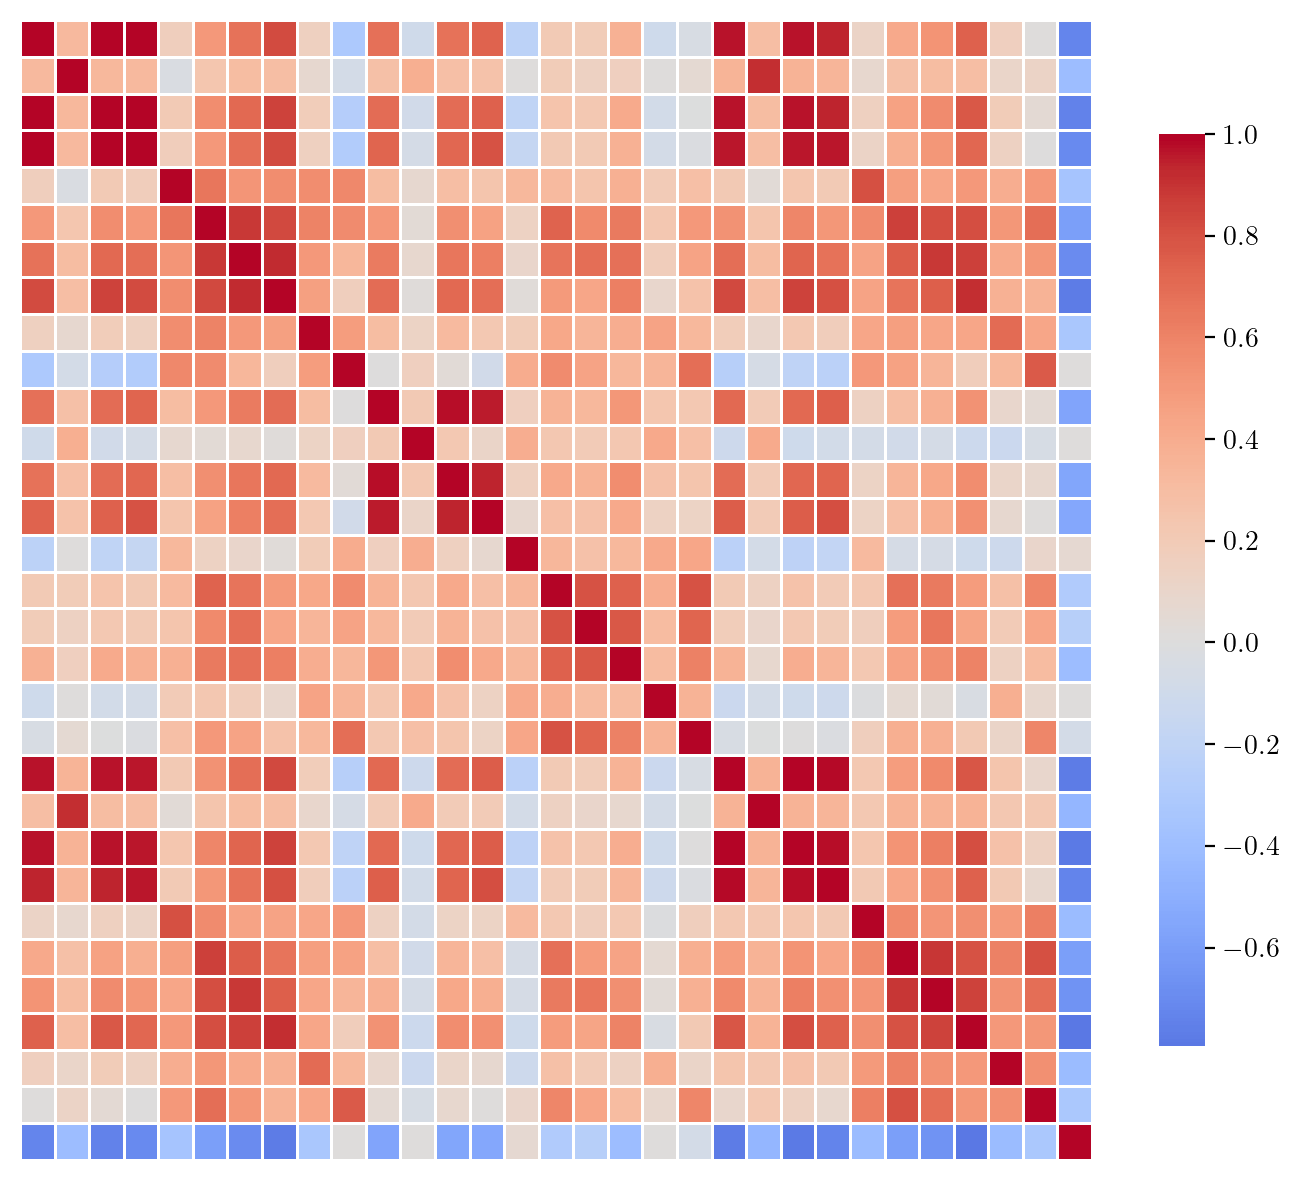

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer

# 1. Load Breast Cancer dataset
data = load_breast_cancer()
X = data.data
y = data.target

# 2. Prepare DataFrame
df = pd.DataFrame(X, columns=data.feature_names)
df["target"] = y  # already numeric (0 = malignant, 1 = benign)

# 3. Compute Correlation Matrix
corr_matrix = df.corr()

# 4. Plot Correlation Matrix
plt.figure(figsize=(7, 6))
sns.heatmap(
    corr_matrix,
    annot=False,      # Set True if you want numbers displayed
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

# turn off x and y labels text
plt.xlabel("")
plt.ylabel("")
#turn off x and y ticks
plt.xticks([])
plt.yticks([])
#plt.title("Correlation Matrix: Breast Cancer Dataset", fontsize=16)
plt.tight_layout()
plt.show()


In [6]:
corr_matrix

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
mean radius,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,-0.311631,...,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066,-0.730029
mean texture,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,-0.076437,...,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205,-0.415185
mean perimeter,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,-0.261477,...,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019,-0.742636
mean area,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,-0.283110,...,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738,-0.708984
mean smoothness,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,0.584792,...,0.036072,0.238853,0.206718,0.805324,0.472468,0.434926,0.503053,0.394309,0.499316,-0.358560
mean compactness,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,0.565369,...,0.248133,0.590210,0.509604,0.565541,0.865809,0.816275,0.815573,0.510223,0.687382,-0.596534
mean concavity,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,0.336783,...,0.299879,0.729565,0.675987,0.448822,0.754968,0.884103,0.861323,0.409464,0.514930,-0.696360
mean concave points,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,0.166917,...,0.292752,0.855923,0.809630,0.452753,0.667454,0.752399,0.910155,0.375744,0.368661,-0.776614
mean symmetry,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,0.479921,...,0.090651,0.219169,0.177193,0.426675,0.473200,0.433721,0.430297,0.699826,0.438413,-0.330499
mean fractal dimension,-0.311631,-0.076437,-0.261477,-0.283110,0.584792,0.565369,0.336783,0.166917,0.479921,1.000000,...,-0.051269,-0.205151,-0.231854,0.504942,0.458798,0.346234,0.175325,0.334019,0.767297,0.012838


Computing NMI matrix...


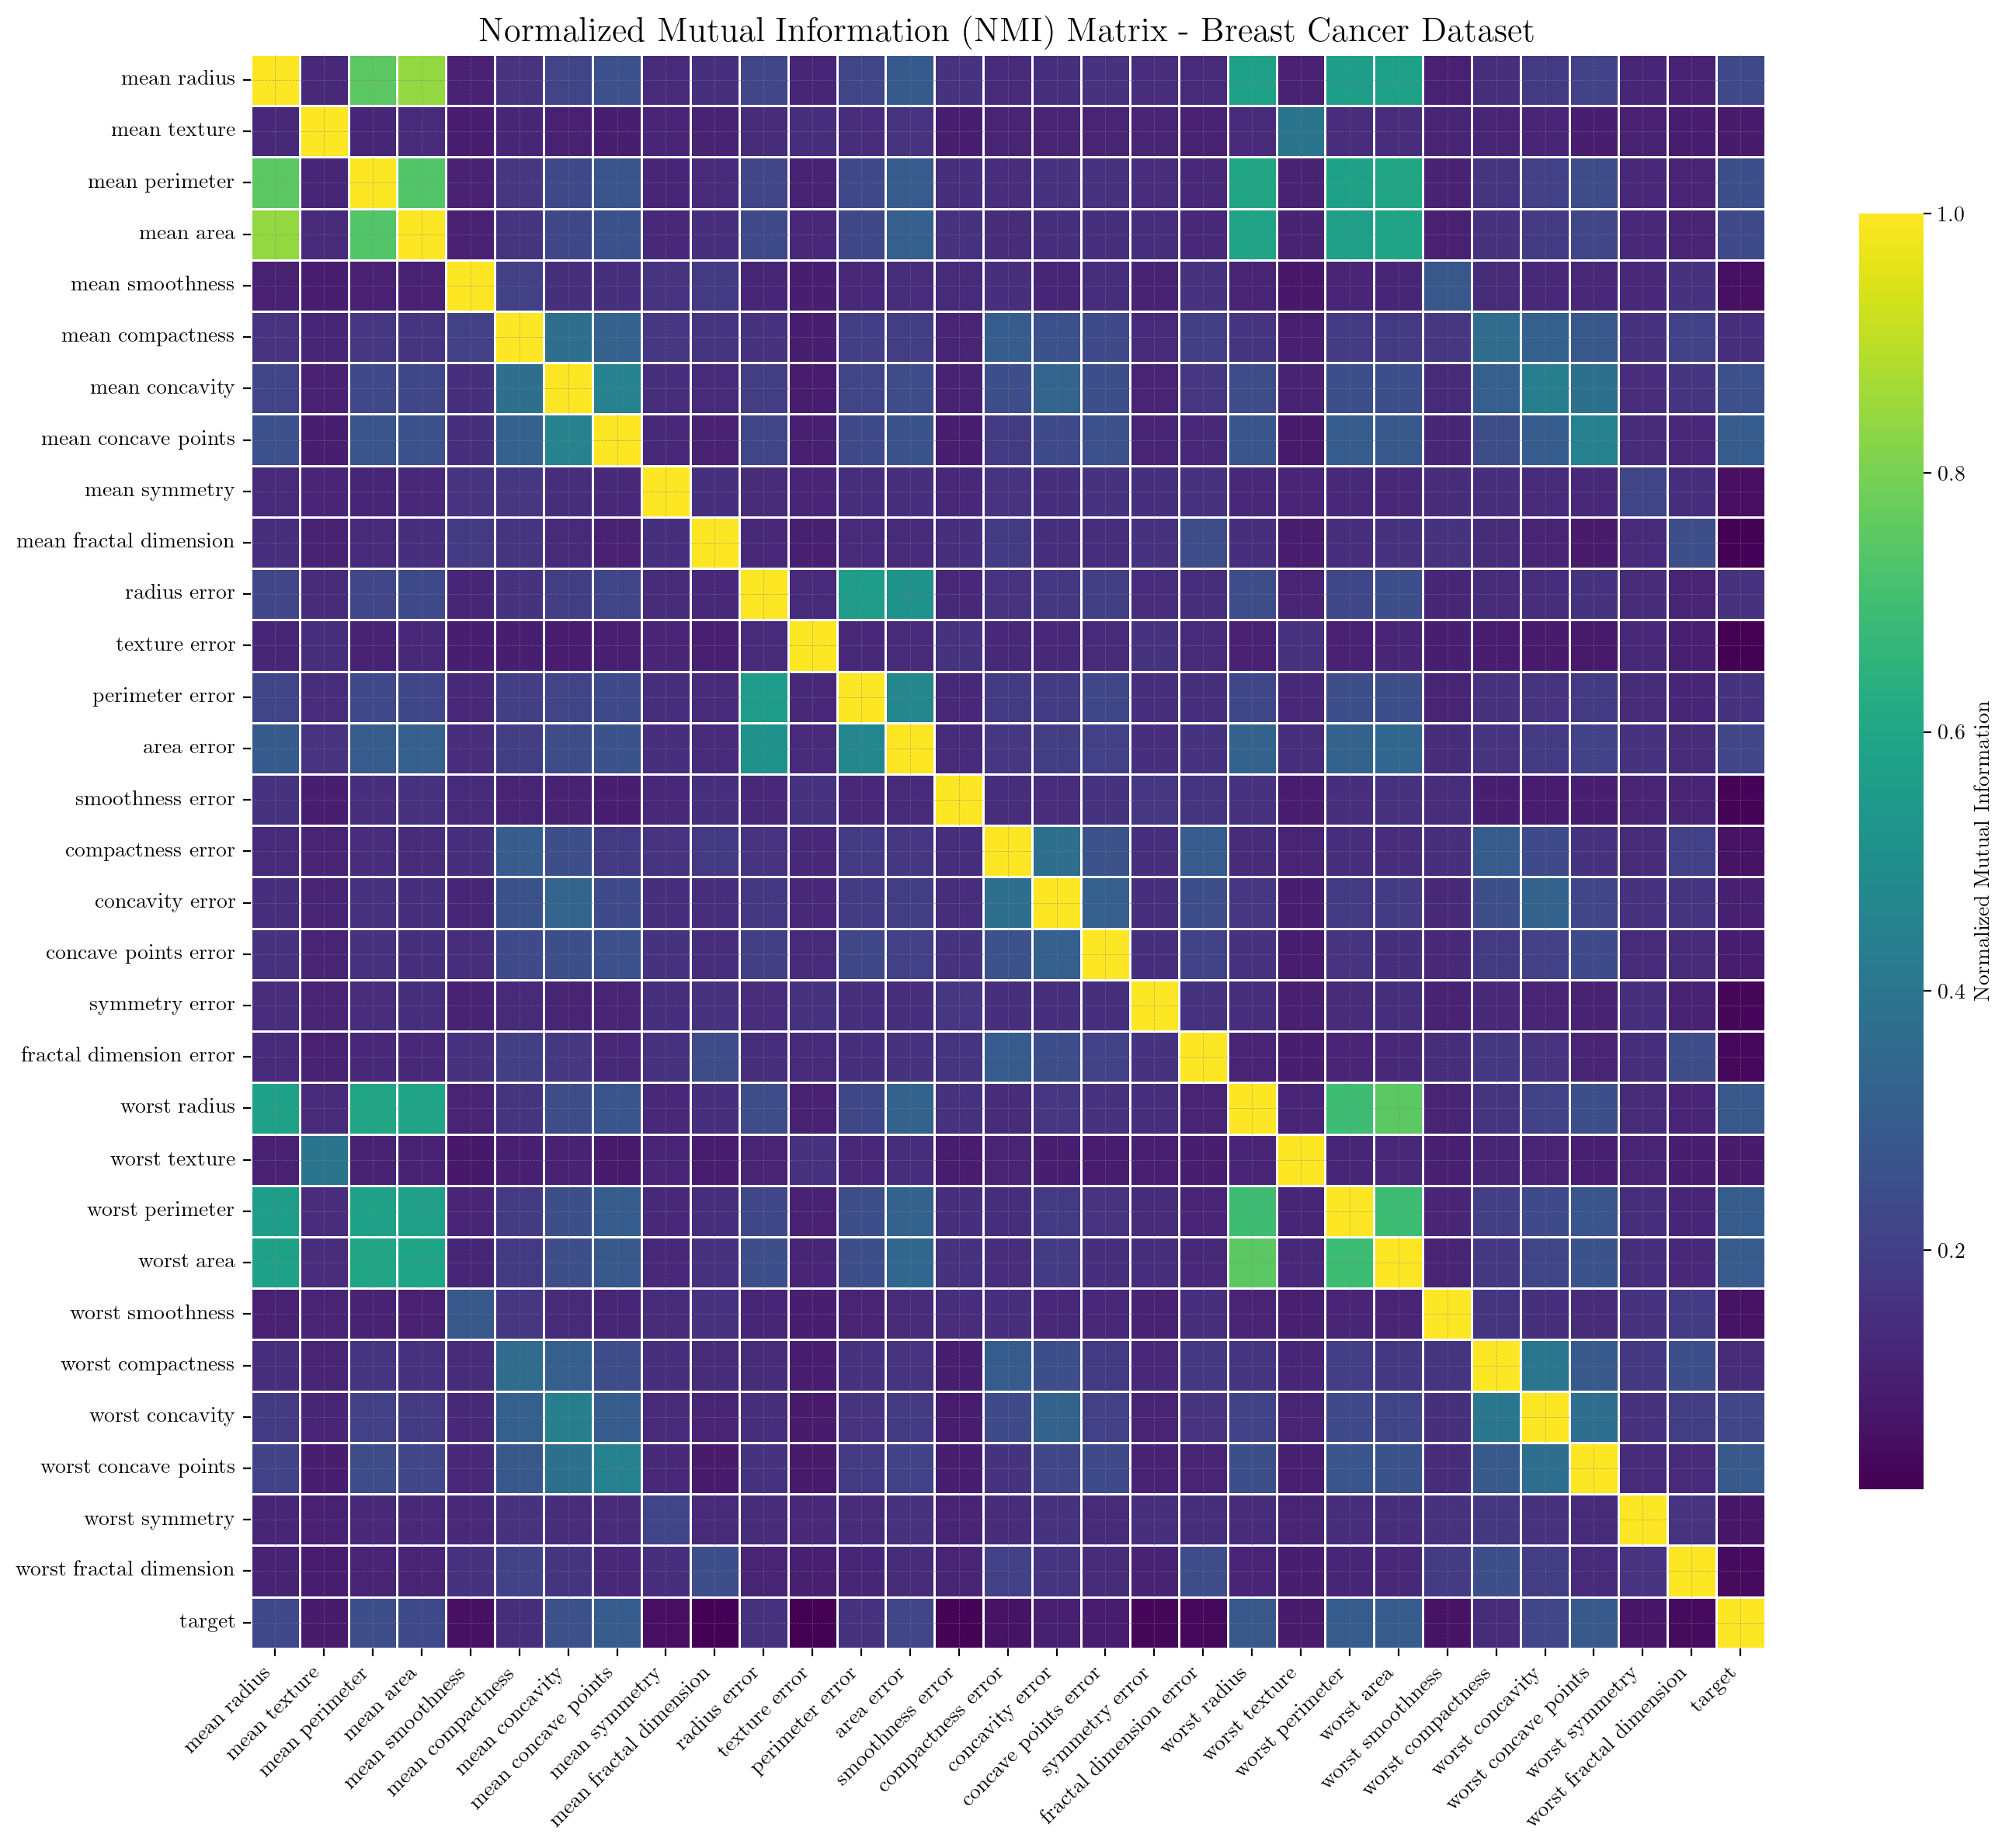

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import load_breast_cancer

# --- 1. Custom Metrics ---
def freedman_diaconis_bins(x):
    x = np.asarray(x).astype(float)
    x = x[~np.isnan(x)]
    if len(x) == 0: 
        return 1
    
    iqr = np.subtract(*np.percentile(x, [75, 25]))
    n = len(x)

    if iqr == 0: 
        return int(np.sqrt(n))

    bin_width = 2 * iqr / (n ** (1/3))
    if bin_width == 0:
        return int(np.sqrt(n))
        
    bins = int(np.ceil((x.max() - x.min()) / bin_width))
    return max(2, bins)

def shannon_entropy(x, bins):
    x = x[~np.isnan(x)]
    hist, _ = np.histogram(x, bins=bins, density=False)
    prob = hist / hist.sum()
    prob = prob[prob > 0]
    return entropy(prob, base=2)

def mutual_information(x, y, bins_x, bins_y):
    mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[mask]
    y = y[mask]
    
    joint_hist, _, _ = np.histogram2d(x, y, bins=[bins_x, bins_y])
    joint_prob = joint_hist / joint_hist.sum()

    px = joint_prob.sum(axis=1)
    py = joint_prob.sum(axis=0)

    mi = 0.0
    for i in range(joint_prob.shape[0]):
        for j in range(joint_prob.shape[1]):
            if joint_prob[i, j] > 0:
                mi += joint_prob[i, j] * np.log2(
                    joint_prob[i, j] / (px[i] * py[j])
                )
    return mi

def normalized_mutual_information(x, y):
    mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[mask].astype(float)
    y = y[mask].astype(float)

    bx = freedman_diaconis_bins(x)
    by = freedman_diaconis_bins(y)

    hx = shannon_entropy(x, bx)
    hy = shannon_entropy(y, by)
    mi = mutual_information(x, y, bx, by)

    if hx + hy == 0: 
        return 0.0
    return 2 * mi / (hx + hy)

# --- 2. Load Breast Cancer Dataset ---
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df["target"] = data.target

# --- 3. Preprocessing ---
df = df.fillna(df.mean(numeric_only=True))

# --- 4. Compute NMI Matrix ---
print("Computing NMI matrix...")
columns = df.columns
n_cols = len(columns)
nmi_matrix = pd.DataFrame(np.zeros((n_cols, n_cols)), index=columns, columns=columns)

for i in range(n_cols):
    for j in range(i, n_cols):
        col1 = columns[i]
        col2 = columns[j]
        
        val = normalized_mutual_information(df[col1].values, df[col2].values)
        nmi_matrix.loc[col1, col2] = val
        nmi_matrix.loc[col2, col1] = val

# --- 5. Plot Heatmap ---
plt.figure(figsize=(14, 12))
sns.heatmap(
    nmi_matrix,
    cmap='viridis',
    annot=False,
    linewidths=0.4,
    cbar_kws={"shrink": .8, "label": "Normalized Mutual Information"}
)
plt.title("Normalized Mutual Information (NMI) Matrix - Breast Cancer Dataset", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [4]:
nmi_matrix

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
mean radius,1.000000,0.127990,0.751705,0.840932,0.105946,0.164226,0.214288,0.254542,0.133217,0.152749,...,0.105001,0.557902,0.575173,0.107865,0.149528,0.178361,0.211457,0.120709,0.111623,0.228362
mean texture,0.127990,1.000000,0.122109,0.132376,0.094177,0.120751,0.107845,0.098416,0.116958,0.108778,...,0.395220,0.140427,0.142246,0.113083,0.113757,0.118336,0.097012,0.104643,0.093295,0.086828
mean perimeter,0.751705,0.122109,1.000000,0.734479,0.106169,0.173318,0.228474,0.272620,0.122461,0.133844,...,0.109916,0.580144,0.594553,0.110215,0.167219,0.201202,0.239556,0.124522,0.112450,0.247786
mean area,0.840932,0.132376,0.734479,1.000000,0.106324,0.166750,0.224826,0.260223,0.124225,0.146787,...,0.110019,0.569343,0.589122,0.105199,0.157654,0.182473,0.220189,0.126561,0.112731,0.232340
mean smoothness,0.105946,0.094177,0.106169,0.106324,1.000000,0.204282,0.150957,0.152521,0.163244,0.181697,...,0.080399,0.116923,0.121147,0.282093,0.138513,0.131072,0.125037,0.125357,0.155945,0.057181
mean compactness,0.164226,0.120751,0.173318,0.166750,0.204282,1.000000,0.372996,0.317146,0.172887,0.169305,...,0.101863,0.188561,0.178078,0.172564,0.359657,0.314011,0.281239,0.156028,0.210855,0.143668
mean concavity,0.214288,0.107845,0.228474,0.224826,0.150957,0.372996,1.000000,0.450865,0.145960,0.132479,...,0.108390,0.253287,0.247283,0.134241,0.311149,0.438595,0.375730,0.142037,0.168078,0.255930
mean concave points,0.254542,0.098416,0.272620,0.260223,0.152521,0.317146,0.450865,1.000000,0.130695,0.106461,...,0.083766,0.296637,0.283963,0.120136,0.242016,0.296684,0.443189,0.134986,0.126940,0.298813
mean symmetry,0.133217,0.116958,0.122461,0.124225,0.163244,0.172887,0.145960,0.130695,1.000000,0.152436,...,0.115881,0.128965,0.126964,0.137575,0.148465,0.132717,0.129166,0.219294,0.142962,0.051678
mean fractal dimension,0.152749,0.108778,0.133844,0.146787,0.181697,0.169305,0.132479,0.106461,0.152436,1.000000,...,0.094064,0.144483,0.156800,0.160257,0.136958,0.115382,0.084976,0.133556,0.249087,0.023221


In [6]:
from sklearn.datasets import load_breast_cancer

from sklearn.feature_selection import GenericUnivariateSelect, chi2

X, y = load_breast_cancer(return_X_y=True)

X.shape

(569, 30)

In [7]:
transformer = GenericUnivariateSelect(chi2, mode='k_best', param=20)

X_new = transformer.fit_transform(X, y)

X_new.shape

(569, 20)

1. **OK** Rank Agreement PFI vs SHAP per model (per dataset)
2. Porównać ten chart z feature selection z większą ilością modeli
3. Compare Top 10 Features found by LR vs XGB (using SHAP as the gold standard for attribution)
4. Runtime & Computation Cost
5. PARTITION EXPLAINER

# Czy wybrana pierwsza kolumna dla regresji logistycznej to ta z największym Corr z targetem (dla SHAP i PFI)? Odp: Nie

Here is the mathematical proof for the Additivity property specifically within the SHAP framework.

This proof relies on the **Linearity of Expectation** (or linearity of the integral), which allows us to decompose the characteristic function of a summed model into the sum of the characteristic functions of its parts.

![image.png](attachment:image.png)

![image-2.png](attachment:image-2.png)

![image-3.png](attachment:image-3.png)

![image-4.png](attachment:image-4.png)

![image-5.png](attachment:image-5.png)